# Data Cleaning

### Importing libraries and loading CSV files

In [111]:
import os
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scikit_posthocs as sp

import requests
from IPython.display import Image, display
from wordcloud import WordCloud

import gender_guesser.detector as gender
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import scipy.stats as stats
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene, ttest_ind_from_stats, chi2_contingency, spearmanr
from scipy.stats import kruskal
from scikit_posthocs import posthoc_conover

import keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder

In [70]:
## Loading the CSV files from local
books = pd.read_csv('books_data/books.csv', sep=';', on_bad_lines="skip", encoding='latin-1')
ratings = pd.read_csv('books_data/ratings.csv', sep=';', on_bad_lines="skip", encoding='latin-1')
users = pd.read_csv('books_data/users.csv', sep=';', on_bad_lines="skip", encoding='latin-1')

## source: https://www.kaggle.com/code/sameergmathad/dsc-478-final-project-book-dataset

/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/443868272.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('books_data/books.csv', sep=';', on_bad_lines="skip", encoding='latin-1')


In [71]:
# Before data cleaning
before_cleaning_books = books.shape
before_cleaning_ratings = ratings.shape
before_cleaning_users = users.shape

print(before_cleaning_books)
print(before_cleaning_ratings)
print(before_cleaning_users)

(271360, 8)
(1149780, 3)
(278858, 3)


### Duplicate Removing

In [72]:
print("Before removing books duplicates:", books.shape)
print("Before removing ratings duplicates:", ratings.shape)
print("Before removing users duplicates:", users.shape)

# remove duplicates (turns out it wasn't necessary because there was none)
books = books.drop_duplicates()
ratings = ratings.drop_duplicates()
users = users.drop_duplicates()

print("After removing books duplicates:", books.shape)
print("After removing ratings duplicates:", ratings.shape)
print("After removing users duplicates:", users.shape)

Before removing books duplicates: (271360, 8)
Before removing ratings duplicates: (1149780, 3)
Before removing users duplicates: (278858, 3)
After removing books duplicates: (271360, 8)
After removing ratings duplicates: (1149780, 3)
After removing users duplicates: (278858, 3)


Further Checks for Duplicates
* Checking for duplicated book entries in books dataset based on ISBN
* Checking for duplicated entries in ratings dataset
* Checking for duplicated entries in users dataset

there was no duplicates

In [73]:
## Subset duplicate checking
# Checking for duplicated book entries in books dataset based on ISBN
print(books.duplicated(subset=['ISBN'], keep='first').value_counts()) # Mark duplicates
# there is no duplicates

# Checking for duplicated entries in ratings dataset
print(ratings.duplicated(subset=['User-ID', 'ISBN'], keep='first').value_counts())
# there is no duplicates

# Checking for duplicated entries in users dataset
print(users.duplicated(subset=['User-ID'], keep='first').value_counts())
# there is no duplicates

False    271360
Name: count, dtype: int64
False    1149780
Name: count, dtype: int64
False    278858
Name: count, dtype: int64


### Small Correction

In [74]:
# While datatype converting, 3 rows were found where the datas were not correctly organized and needed to be shifted
needs_shift = books['Image-URL-L'].isna()

# Print to see what's wrong
# print(books[needs_shift])

# Correction: shift the values to their right columns
books.loc[needs_shift, "Year-Of-Publication":"Image-URL-L"] = books.loc[needs_shift, "Book-Author":"Image-URL-L"].shift(1, axis=1)

# get author info that got stuck in book title value
wrong_title = books[needs_shift]['Book-Title'].str.split(';')
books.loc[needs_shift, ['Book-Title']] = wrong_title.str[0].str[:-2]
books.loc[needs_shift, ['Book-Author']] = wrong_title.str[-1].str[:-1]

# Print corrected version
# print(books[needs_shift])

### ISBN format checker

In [75]:
# check during
# before data cleaning
print(books.shape)
print(ratings.shape)
print(users.shape)

(271360, 8)
(1149780, 3)
(278858, 3)


In [76]:
# Checking if ISBN is in correct format
def is_valid_isbn(isbn):

    if len(isbn) == 10: # ISBN-10
        if not re.match(r'^\d{9}[\dX]$', isbn):
            return False

        # Calculate the check digit
        total = 0
        for i, char in enumerate(isbn[:-1]):  # Exclude the last character (check digit)
            total += (i + 1) * int(char)

        # Calculate the correct check digit
        check_digit = total % 11
        if check_digit == 10:
            check_digit = 'x'
        else:
            check_digit = str(check_digit)

    # Compare the calculated check digit with the last character of the ISBN
        return check_digit == isbn[-1].lower()

    elif len(isbn) == 13: # ISBN-13
        if not re.match(r'^\d{13}$', isbn):
            return False

        # Calculate the check digit
        total = 0
        for i, char in enumerate(isbn[:-1]):  # Exclude the last digit (check digit)
            digit = int(char)
            if i % 2 == 0:  # Even index (0-based), multiply by 1
                total += digit
            else:  # Odd index, multiply by 3
                total += digit * 3

        # Calculate the correct check digit
        check_digit = (10 - (total % 10)) % 10

        # Compare the calculated check digit with the last digit of the ISBN
        return check_digit == int(isbn[-1])

    return False


# Apply the function to the ISBN column of books and ratings to filter out bad ISBNs
books = books.loc[books['ISBN'].apply(is_valid_isbn)] # 529 bad ISBNs is filtered
ratings = ratings.loc[ratings['ISBN'].apply(is_valid_isbn)] # 7069 bad ISBNs is filtered


In [77]:
# check during
# after data cleaning
print(books.shape)
print(ratings.shape)
print(users.shape)

(270831, 8)
(1133978, 3)
(278858, 3)


### Filtering Impossible Age Values

/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/3229120801.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=users['Age'], palette='magma')


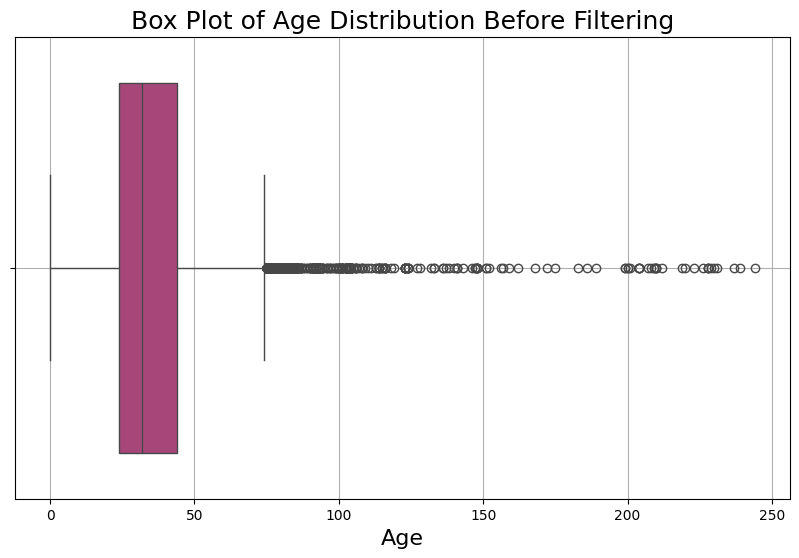

In [78]:
# Box Plot to see age distribution before filtering
plt.figure(figsize=(10, 6))
sns.boxplot(x=users['Age'], palette='magma')
plt.xlabel('Age', fontsize=16)
plt.title('Box Plot of Age Distribution Before Filtering', fontsize=18)
plt.grid(True)
plt.show()

In [79]:
# Longest human age on record: 122
# source: https://en.wikipedia.org/wiki/List_of_the_verified_oldest_people#:~:text=The%20oldest%20person%20ever%20whose,116%20years%20and%2054%20days.
# Average age for learning to read is 6-7

# Count valid ages before filtering
valid_ages_before = users['Age'].notna().sum()

# Replace unrealistic ages with NaN
age_filter = users['Age'].between(5, 123) # age range
users['Age'] = users['Age'].where(age_filter) # fill values outside of age range with NaN

# Count valid ages after filtering
valid_ages_after = users['Age'].notna().sum()

# Calculate the number of ages filtered
ages_filtered = valid_ages_before - valid_ages_after
print(f"Number of ages filtered: {ages_filtered}")

# Calculate total number of NaN values
total_nan = users['Age'].isna().sum()
print(f"Number of NaN values: {total_nan}, percentage compared to total: {total_nan/len(users)*100}%")

Number of ages filtered: 952
Number of NaN values: 111714, percentage compared to total: 40.06124981173214%


### Datatype Conversions

In [80]:
# Convert publication year column to int
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [81]:
# Split Location column into new columns

# Source inspiration: https://www.kaggle.com/code/sameergmathad/dsc-478-final-project-book-dataset

# Drop the location values that have missing information
drop_indeces = users[users['Location'].str.split(",").str.len() != 3].index
users = users.drop(index = drop_indeces)

# Split Location column to 3 columns: City, State, Country
users[['City','State','Country']] = users['Location'].str.strip().str.split(", ", expand=True, n=2)

# Strip location values
users['City'] = users['City'].str.strip()
users['State'] = users['State'].str.strip()
users['Country'] = users['Country'].str.strip()

### Handle Missing Values in Books & Ratings

In [82]:
# Find missing values in the Books dataset
print(books.isna().sum())
#books[books.isna().any(axis=1)] # to see directly

# Missing 2 author values
# Missing 2 publisher values

# Drop the rows with missing values
books = books.dropna()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64


In [83]:
# Find missing values in the Ratings dataset
ratings.isna().sum()

# Missing none

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

### String names format check for Title, Author name, Publisher name

In [84]:
# Function to format author names
def name_formatter(name):
    # Strip leading and trailing whitespace
    name = name.strip()
    # Remove weird characters
    name = re.sub(r'[^a-zA-Z0-9\s\'\-\.&,]', '', name)
    # Lowercase
    name = name.lower()
    # Return capitalized
    return name.title()


# Clean string names
books['Book-Title'] = books['Book-Title'].apply(name_formatter)
books['Book-Author'] = books['Book-Author'].apply(name_formatter)
books['Publisher'] = books['Publisher'].apply(name_formatter)

# Fix encoding issues
books['Book-Title'] = books['Book-Title'].apply(lambda x: x.encode('latin-1').decode('latin-1', errors='ignore'))
books['Book-Author'] = books['Book-Author'].apply(lambda x: x.encode('latin-1').decode('latin-1', errors='ignore'))
books['Publisher'] = books['Publisher'].apply(lambda x: x.encode('latin-1').decode('latin-1', errors='ignore'))

### Handle Missing Values in Users

Handling missing age values

/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/2597519493.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=users['Age'], palette='magma')


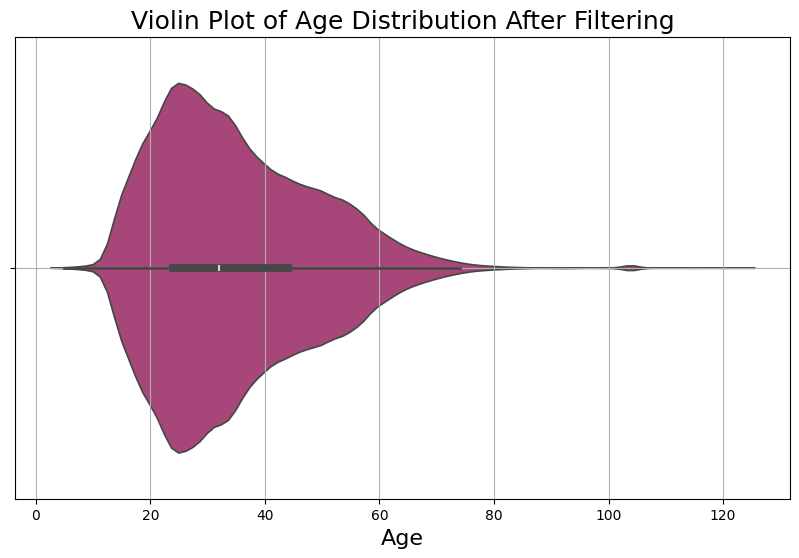

In [85]:
# Violin Plot to see Age Distribution After Filtering
plt.figure(figsize=(10, 6))
sns.violinplot(x=users['Age'], palette='magma')
plt.xlabel('Age', fontsize=16)
plt.title('Violin Plot of Age Distribution After Filtering', fontsize=18)
plt.grid(True)
plt.show()


In [86]:
# Replace NaN with median age
age_median = users['Age'].median()
users['Age'].fillna(age_median, inplace=True)

/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/498195839.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  users['Age'].fillna(age_median, inplace=True)


/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/230042557.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=users['Age'], palette='magma')


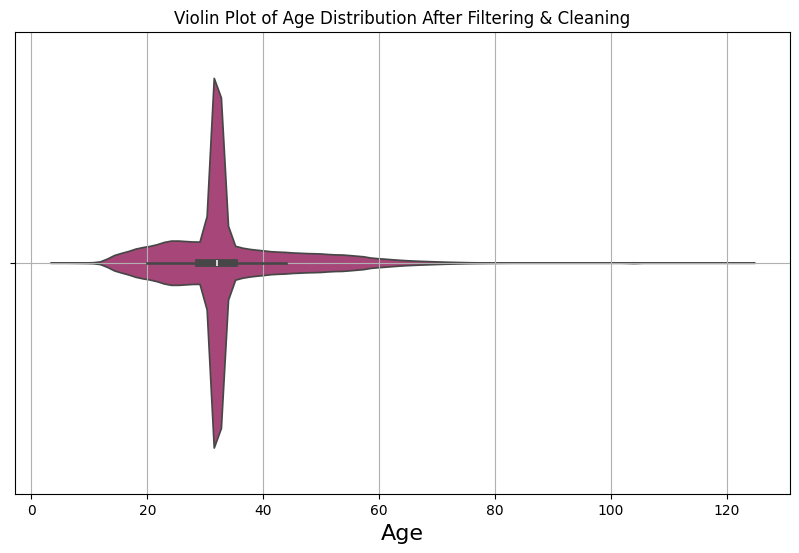

In [87]:
# Violin Plot to see Age Distribution After Filtering & Cleaning
plt.figure(figsize=(10, 6))
sns.violinplot(x=users['Age'], palette='magma')
plt.xlabel('Age', fontsize=16)
plt.title('Violin Plot of Age Distribution After Filtering & Cleaning')
plt.grid(True)
plt.show()

Locating and filtering out empty or unvalid location values

In [88]:
print("Before filtering users:", users.shape)

# Function to filter out location names
def filter_and_capitalize_location(location):
    # Check if NaN
    if pd.isna(location):
        return pd.NA
    # Lowercase
    location = location.lower()
    # Check if 'none' or 'n/a'
    if location in ['none', 'n/a']:
        return pd.NA
    # Check for weird characters using regex
    if re.search(r"[^a-z,. ']", location):
        return pd.NA

    return location.title()


# Apply the function to filter locations
users['City'] = users['City'].apply(filter_and_capitalize_location)
users['State'] = users['State'].apply(filter_and_capitalize_location)
users['Country'] = users['Country'].apply(filter_and_capitalize_location)

# Drop empty values
users = users.dropna(subset=['City', 'Country'])

# Replace empty or invalid state values with country info
users['State'] = users.apply(lambda row: row['Country'] if pd.isna(row['State']) else row['City'], axis=1)

print("After filtering users:", users.shape)

Before filtering users: (277348, 6)
After filtering users: (261924, 6)


### Filtering 0 ratings (implicit rating)

In [89]:
# Create a DataFrame with all ratings
all_ratings = ratings.copy()

# Create a DataFrame excluding ratings with a value of 0
ratings = ratings[ratings['Book-Rating'] != 0]

print(f"Number of filtered out ratings (0 ratings): {len(all_ratings) - len(ratings)} which was { len(ratings) / len(all_ratings) * 100 }% of the whole dataset.")

Number of filtered out ratings (0 ratings): 707376 which was 37.619953826264705% of the whole dataset.


### Filter out ratings & users referencing to non-existent values in other datasets


In [90]:
print("Before filtering ratings:", ratings.shape)
print("Before filtering users:", users.shape)

# Filter out ratings referencing non-existent books
ratings = ratings[ratings['ISBN'].isin(books['ISBN'])]
# ratings # before 433671 rows, after 383837 rows

# Filter out users that don't have a rating
users = users[users['User-ID'].isin(ratings['User-ID'])]
# users # before 278858 rows, after 68091 rows

print("After filtering ratings:", ratings.shape)
print("After filtering users:", users.shape)

Before filtering ratings: (426602, 3)
Before filtering users: (261924, 6)
After filtering ratings: (383582, 3)
After filtering users: (64045, 6)


### Results of data cleaning

In [91]:
# After data cleaning
after_cleaning_books = books.shape
after_cleaning_ratings = ratings.shape
after_cleaning_users = users.shape

print(after_cleaning_books)
print(after_cleaning_ratings)
print(after_cleaning_users)

# before it was
#(271360, 8)
#(1149780, 3)
#(278858, 3)

(270827, 8)
(383582, 3)
(64045, 6)


In [92]:
print("How data cleaning changed each dataset shape")
print(f"Books: {before_cleaning_books} has been changed into {after_cleaning_books} -> {round((1-after_cleaning_books[0]/before_cleaning_books[0])*100, 2)}% has been cleaned.")
print(f"Ratings: {before_cleaning_ratings} has been changed into {after_cleaning_ratings} -> {round((1-after_cleaning_ratings[0]/before_cleaning_ratings[0])*100, 2)}% has been cleaned.")
print(f"Users: {before_cleaning_users} has been changed into {after_cleaning_users} -> {round((1-after_cleaning_users[0]/before_cleaning_users[0])*100, 2)}% has been cleaned.")

How data cleaning changed each dataset shape
Books: (271360, 8) has been changed into (270827, 8) -> 0.2% has been cleaned.
Ratings: (1149780, 3) has been changed into (383582, 3) -> 66.64% has been cleaned.
Users: (278858, 3) has been changed into (64045, 6) -> 77.03% has been cleaned.


# Data Analysis

## Best & Worst Authors, Publishers, and Books for All and for Different Age Groups

###Best and Worst Rated Authors


First, let's look at rating count distribution.

/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/3218653614.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=rating_counts['Ratings-Count'], palette='magma')


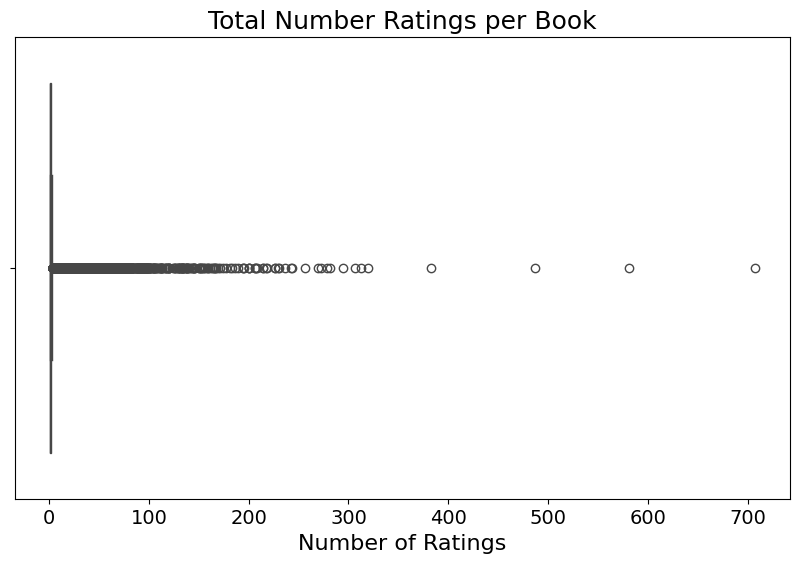

0.50    18.0
0.75    29.0
0.85    40.0
0.95    77.0
Name: Ratings-Count, dtype: float64


In [93]:
# Calculate the number of ratings for each book
rating_counts = ratings.groupby('ISBN').size().reset_index(name='Ratings-Count')

# Seeing the distribution of number of ratings per book to decide on a min threshold
plt.figure(figsize=(10, 6))
sns.boxplot(x=rating_counts['Ratings-Count'], palette='magma')
plt.xlabel('Number of Ratings', fontsize=16)
plt.title('Total Number Ratings per Book', fontsize=18)
plt.xticks(fontsize=14)
plt.show()

x = rating_counts[rating_counts['Ratings-Count']>10]['Ratings-Count'].quantile([0.5, 0.75, 0.85, 0.95])
print(x)

We chose the min rating count threshold between Q3 and Q4 to reduce the noise of low numbered ratings and increase reliability by including a larger sample size in the analysis.

In [94]:
# Set a threshold for the minimum number of ratings
min_rat_threshold = 40

In [95]:
# Merge ratings and books on ISBN
merged_data_rb = ratings.merge(books, on='ISBN')

# Group by authors and calculate average ratings
author_ratings = merged_data_rb.groupby('Book-Author')['Book-Rating'].agg(['mean', 'count']).reset_index()
author_ratings.columns = ['Book-Author', 'Average-Rating', 'Rating-Count']

# Filter out based on min rating count threshold
filtered_author_ratings = author_ratings[author_ratings['Rating-Count'] >= min_rat_threshold]

# Best and worst rated authors
best_authors = filtered_author_ratings.sort_values(by='Average-Rating', ascending=False).head(10)
worst_authors = filtered_author_ratings.sort_values(by='Average-Rating', ascending=False).tail(10)

print("Top 10 Best Rated Authors:")
print(best_authors)
print("\nTop 10 Worst Rated Authors:")
print(worst_authors)

Top 10 Best Rated Authors:
                   Book-Author  Average-Rating  Rating-Count
39590       Maud Hart Lovelace        9.288462            52
3738            Art Spiegelman        9.285714            56
14695                Dr. Seuss        9.189320           206
5713            Bill Watterson        9.186186           333
31032         Juliet Marillier        9.166667            42
52593         Shel Silverstein        9.158730           126
3402   Antoine De Saint-Exupry        9.034682           173
6201     Bradley Trevor Greive        8.988095            84
21608               Harper Lee        8.985765           281
9826                     Clamp        8.982759           116

Top 10 Worst Rated Authors:
                       Book-Author  Average-Rating  Rating-Count
59890            Wolfgang Hohlbein        6.250000           100
39362  Mary-Kate &Amp Ashley Olsen        6.142857            42
45182                  Paul Zindel        6.120370           108
22381        

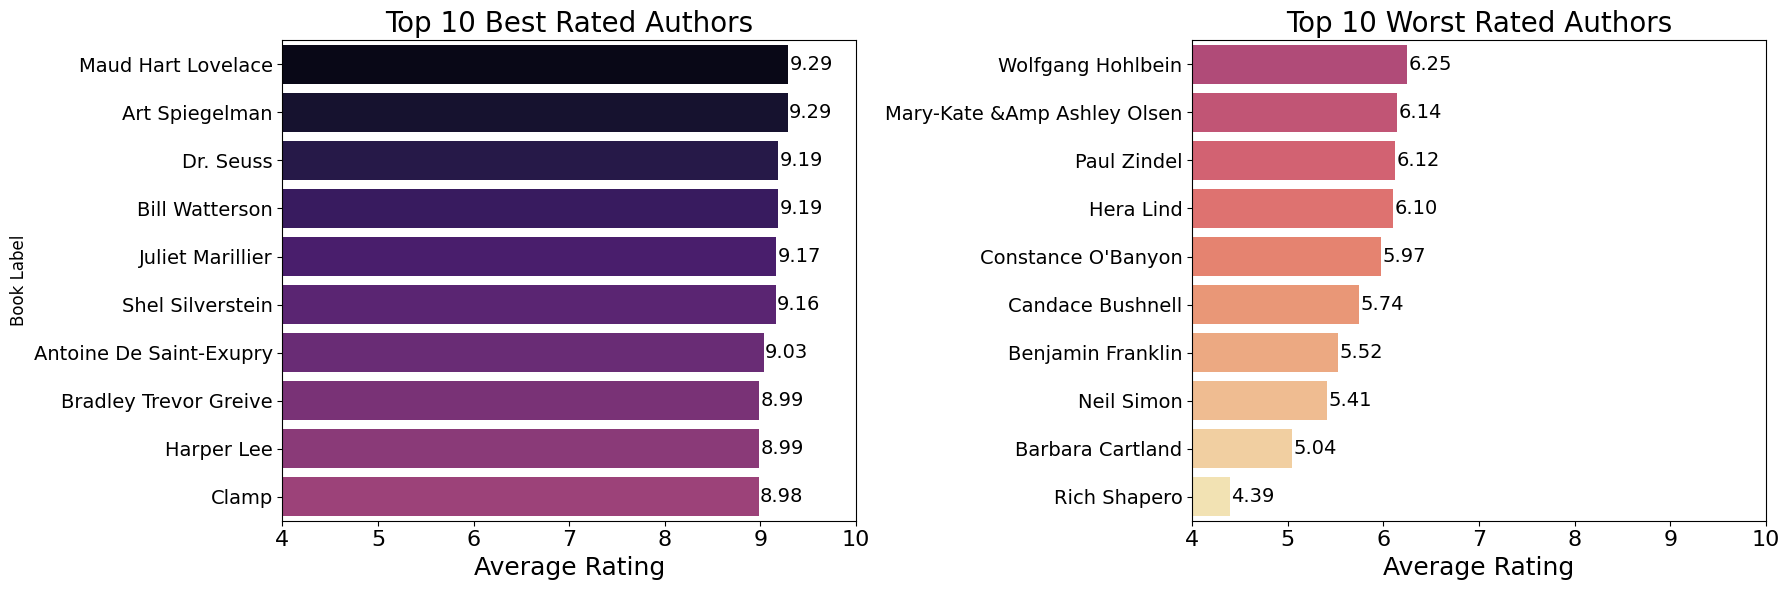

In [96]:
magma_palette = sns.color_palette("magma", n_colors=20)
# Plotting
plt.figure(figsize=(18, 6))

# Best Rated Authors
plt.subplot(1, 2, 1)
bars= sns.barplot(data=best_authors, y='Book-Author', x='Average-Rating', palette=magma_palette[:10][::-1], hue='Average-Rating', legend=False)
plt.title('Top 10 Best Rated Authors', fontsize=20)
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('Book Label', fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.xlim(4, 10)

# Adding annotations
for container in bars.containers:
    bars.bar_label(container, fmt='%.2f', fontsize=14, padding=1)

# Worst Rated Authors
plt.subplot(1, 2, 2)
bars2= sns.barplot(data=worst_authors, y='Book-Author', x='Average-Rating', palette=magma_palette[10:][::-1], hue='Average-Rating', legend=False)
plt.title('Top 10 Worst Rated Authors', fontsize=20)
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('')
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.xlim(4, 10)

# Adding annotations
for container in bars2.containers:
    bars2.bar_label(container, fmt='%.2f', fontsize=14, padding=1)


plt.tight_layout()
plt.show()

###Best and Worst Rated Publishers



Top 5 Best Rated Publishers:
                    Publisher  Average-Rating  Rating-Count
1822      Carlsen Verlag Gmbh        9.117647            51
690    Arthur A. Levine Books        8.910448           335
4578       Harry N Abrams Inc        8.825000            40
3693             Five Star Me        8.821622           185
10149                Tokyopop        8.781333           375

Top 5 Worst Rated Publishers:
                           Publisher  Average-Rating  Rating-Count
6719                  Modern Library        6.477419           620
4492                 Harlequin Books        6.455556            90
4495   Harlequin Mills &Amp Boon Ltd        6.333333            57
10386        Ulverscroft Large Print        6.282609            46
10156                        Too Far        4.390706           581


/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/3734085733.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=best_publishers, y='Publisher', x='Average-Rating', palette=magma_palette[:10:2])
/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/3734085733.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=worst_publishers, y='Publisher', x='Average-Rating', palette=magma_palette[10::2])


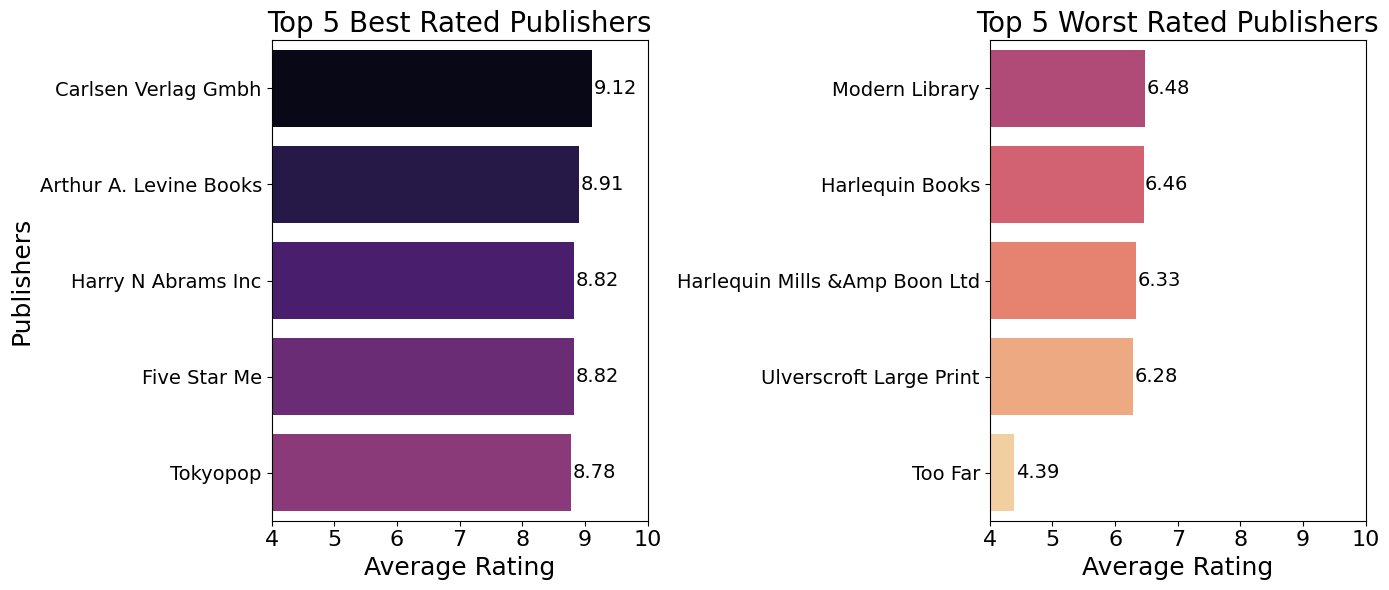

In [97]:
# Group by publisher and calculate average ratings
publisher_ratings = merged_data_rb.groupby('Publisher')['Book-Rating'].agg(['mean', 'count']).reset_index()
publisher_ratings.columns = ['Publisher', 'Average-Rating', 'Rating-Count']

# Filter out based on min rating count threshold
filtered_publisher_ratings = publisher_ratings[publisher_ratings['Rating-Count'] >= min_rat_threshold]

# Best and worst rated publishers
best_publishers = filtered_publisher_ratings.sort_values(by='Average-Rating', ascending=False).head(5)
worst_publishers = filtered_publisher_ratings.sort_values(by='Average-Rating', ascending=False).tail(5)

print("\nTop 5 Best Rated Publishers:")
print(best_publishers)
print("\nTop 5 Worst Rated Publishers:")
print(worst_publishers)

# Plotting
plt.figure(figsize=(14, 6))

# Best Rated Publishers
plt.subplot(1, 2, 1)
bars = sns.barplot(data=best_publishers, y='Publisher', x='Average-Rating', palette=magma_palette[:10:2])
plt.title('Top 5 Best Rated Publishers', fontsize=20)
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('Publishers', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.xlim(4, 10)

# Adding annotations
for container in bars.containers:
    bars.bar_label(container, fmt='%.2f', fontsize=14, padding=1)

# Worst Rated Publishers
plt.subplot(1, 2, 2)
bars = sns.barplot(data=worst_publishers, y='Publisher', x='Average-Rating', palette=magma_palette[10::2])
plt.title('Top 5 Worst Rated Publishers', fontsize=20)
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('')
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.xlim(4, 10)

# Adding annotations
for container in bars.containers:
    bars.bar_label(container, fmt='%.2f', fontsize=14, padding=1)

plt.tight_layout()
plt.show()

### Most rated Authors/Publishers

In [98]:
# Frequencies of Book Ratings
most_rated_books = merged_data_rb['Book-Title'].value_counts().reset_index()
most_rated_books.columns = ['Book-Title', 'Rating-Count']
most_rated_books = most_rated_books.head(10)

# Frequencies of Author Ratings
most_rated_authors = merged_data_rb['Book-Author'].value_counts().reset_index()
most_rated_authors.columns = ['Book-Author', 'Rating-Count']
most_rated_authors = most_rated_authors.head(10)

print("\nMost Rated Books:")
print(most_rated_books)

print("\nMost Rated Authors:")
print(most_rated_authors)


Most Rated Books:
                          Book-Title  Rating-Count
0           The Lovely Bones A Novel           707
1                        Wild Animus           581
2                  The Da Vinci Code           494
3            The Secret Life Of Bees           406
4          The Nanny Diaries A Novel           393
5  The Red Tent Bestselling Backlist           383
6              Bridget Jones'S Diary           377
7                    A Painted House           365
8                         Life Of Pi           336
9          Girl With A Pearl Earring           333

Most Rated Authors:
          Book-Author  Rating-Count
0        Stephen King          4700
1        John Grisham          3666
2        Nora Roberts          3000
3     James Patterson          2387
4       J. K. Rowling          1741
5  Mary Higgins Clark          1713
6    Michael Crichton          1703
7           Anne Rice          1630
8     Janet Evanovich          1489
9      Dean R. Koontz          1473


### Top 10 best/worst rated books
Only doing a average rating comparison was boring because best ones have 10 and worst ones have 0 average rating.


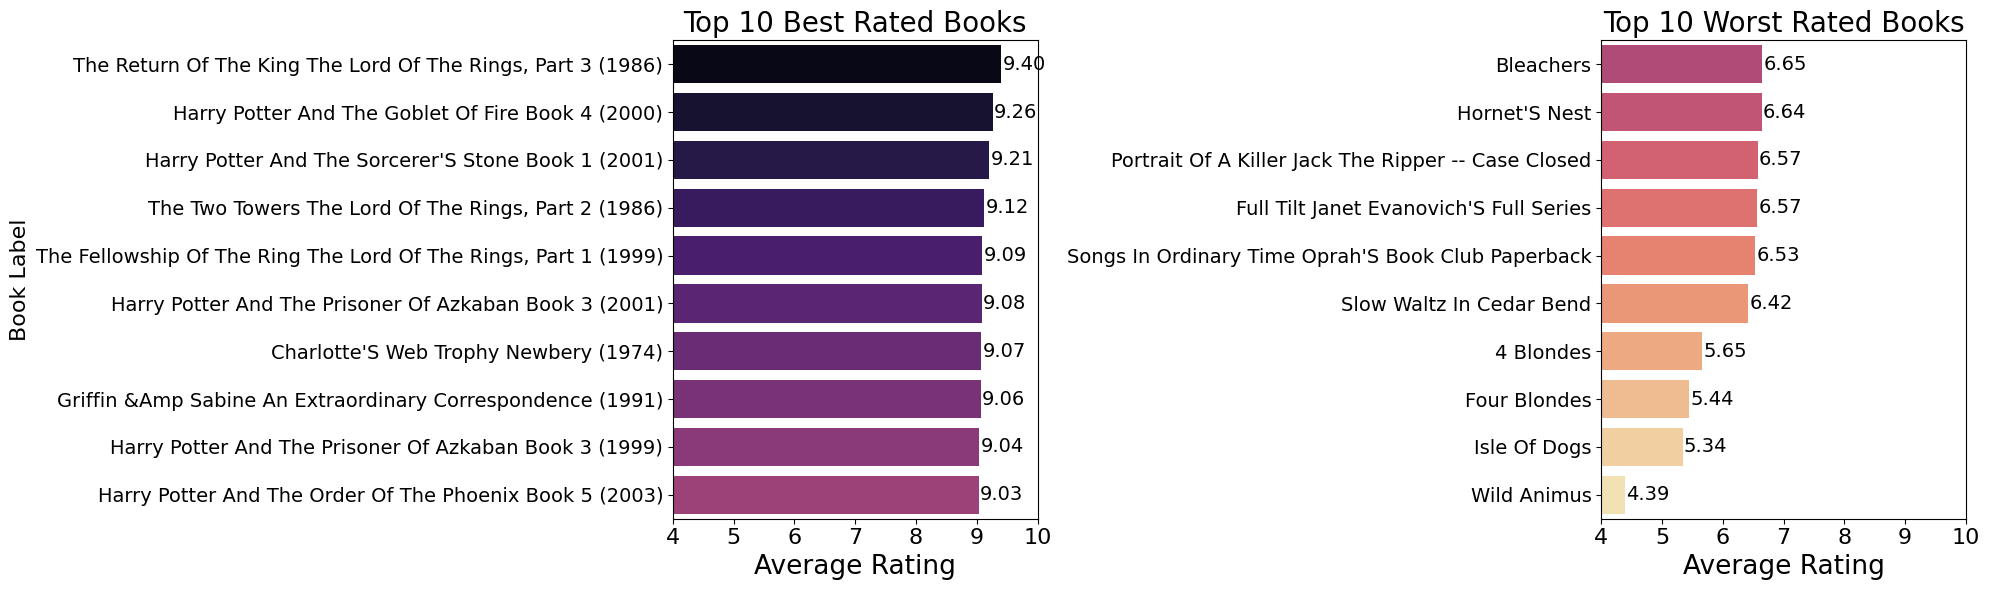

In [99]:
# Filter books with at least min_ratings_threshold ratings
ratings_filtered = rating_counts[rating_counts['Ratings-Count'] >= min_rat_threshold]

# Calculate average ratings per book
avg_ratings = ratings.groupby('ISBN')['Book-Rating'].mean().reset_index(name='Avg-Rating')

# Merge the books with filtered ratings & average ratings
ratings_info = pd.merge(avg_ratings, ratings_filtered, on='ISBN')
books_ratings = pd.merge(ratings_info, books, on='ISBN')

# Add new book label because there are multiple books with the same name but with different ISBNs and publication years
books_ratings['Book-Label'] = books_ratings['Book-Title'] + ' (' + books_ratings['Year-Of-Publication'].astype(str) + ')'

# Sort book ratings
sorted_book_ratings = books_ratings.sort_values(by='Avg-Rating', ascending=False)

# Top 10 best rated books
top_10_best_rated = sorted_book_ratings.head(10).reset_index()

# Top 10 worst rated books
top_10_worst_rated = sorted_book_ratings.tail(10).reset_index()

# Plotting
plt.figure(figsize=(20, 6))

# Best Rated Books
plt.subplot(1, 2, 1)
bars = sns.barplot(data=top_10_best_rated, y='Book-Label', x='Avg-Rating', palette=magma_palette[:10][::-1], hue='Avg-Rating', legend=False)
plt.title('Top 10 Best Rated Books', fontsize=20)
plt.xlabel('Average Rating', fontsize=19)
plt.ylabel('Book Label', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.xlim(4, 10)

# Adding annotations
for container in bars.containers:
    bars.bar_label(container, fmt='%.2f', fontsize=14, padding=1)

# Worst Rated Books
plt.subplot(1, 2, 2)
bars = sns.barplot(data=top_10_worst_rated, y='Book-Title', x='Avg-Rating', palette=magma_palette[10:][::-1],hue='Avg-Rating', legend=False)
plt.title('Top 10 Worst Rated Books', fontsize=20)
plt.xlabel('Average Rating', fontsize=19)
plt.ylabel('')
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.xlim(4, 10)

# Adding annotations
for container in bars.containers:
    bars.bar_label(container, fmt='%.2f', fontsize=14, padding=1)

plt.tight_layout()
plt.show()

Best rated book:
http://images.amazon.com/images/P/0345339738.01.LZZZZZZZ.jpg


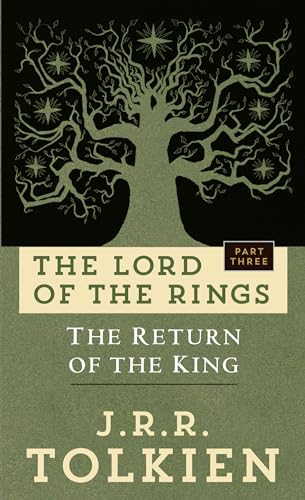

In [100]:
# Get image of best book
def display_image(url):
    try:
        # Fetch image data from URL
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            # Display image
            display(Image(data=response.content))
        else:
            print(f"Failed to fetch image from {url}. Status code: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching image: {e}")

best_image_url = top_10_best_rated.loc[0,'Image-URL-L']

print("Best rated book:")
print(best_image_url)
display_image(best_image_url)

### Which books are most popular by people who dislike the most popular book?

In [101]:
# Get best book info
best_book = top_10_best_rated.loc[0]
print(best_book)

index                                                                144
ISBN                                                          0345339738
Avg-Rating                                                      9.402597
Ratings-Count                                                         77
Book-Title             The Return Of The King The Lord Of The Rings, ...
Book-Author                                               J.R.R. Tolkien
Year-Of-Publication                                                 1986
Publisher                                                        Del Rey
Image-URL-S            http://images.amazon.com/images/P/0345339738.0...
Image-URL-M            http://images.amazon.com/images/P/0345339738.0...
Image-URL-L            http://images.amazon.com/images/P/0345339738.0...
Book-Label             The Return Of The King The Lord Of The Rings, ...
Name: 0, dtype: object


In [102]:
# We already know which book is best from previous question
print(f"Most Popular Book Title: {best_book['Book-Title']}")

# Find users who disliked this book (who rated the best book <= threshold)
dislike_threshold = 5 # lower numbers didn't show any users
users_who_dissed_best_book = ratings[(ratings['ISBN'] == best_book['ISBN']) & (ratings['Book-Rating'] <= dislike_threshold)]
print(f"Number of users who disliked(rated<={dislike_threshold}) the most popular book: {len(users_who_dissed_best_book)}\n")

# Find the other books rated by these users
ratings_by_dis = ratings.loc[(ratings['User-ID'].isin(users_who_dissed_best_book['User-ID']))]

# Calculate the number of ratings for each book
ratings_by_dis.groupby('ISBN').size().describe()
# Since rating counts are very low we don't need a min_rat_threshold

Most Popular Book Title: The Return Of The King The Lord Of The Rings, Part 3
Number of users who disliked(rated<=5) the most popular book: 2



count    1935.000000
mean        1.001034
std         0.032141
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
dtype: float64

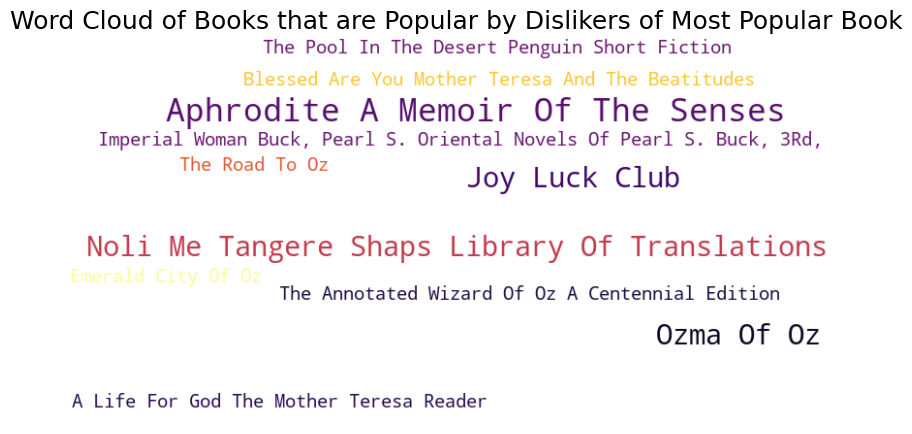

In [103]:
# Calculate average ratings per book
avg_ratings_by_dis = ratings_by_dis.groupby('ISBN')['Book-Rating'].mean().reset_index(name='Avg-Rating')

# Merge the books with average ratings
books_ratings_by_dis = pd.merge(avg_ratings_by_dis, books, on='ISBN')

# Sort book ratings
sorted_book_ratings_by_dis = books_ratings_by_dis.sort_values(by='Avg-Rating', ascending=False)

# Most popular books(rate=10)
best_rated_by_dis = sorted_book_ratings_by_dis[sorted_book_ratings_by_dis['Avg-Rating']==10]

# Create a dictionary of titles and their avg ratings for the word cloud
title_ratings = {title: 1 for title in best_rated_by_dis['Book-Title']}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='inferno', collocations=False, min_font_size=18).generate_from_frequencies(title_ratings)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Books that are Popular by Dislikers of Most Popular Book', fontsize=18)
plt.show()

### Best/Worst Rated Book per Age Group


In [104]:
# Merge all datasets
all_data = ratings.merge(users, on='User-ID').merge(books, on='ISBN')

# Group users into age groups
age_groups = [6, 18, 30, 40, 50, 60, 122]
age_labels = ['6-18', '19-30', '31-40', '41-50', '51-60', '60+']
all_data['Age-Group'] = pd.cut(all_data['Age'], bins=age_groups, labels=age_labels, right=False)

print("Age Group Values Count")
print(all_data['Age-Group'].value_counts())

# Calculate the number of ratings for each book within each age group
rat_counts_by_age = all_data.groupby(['Age-Group', 'Book-Title']).size().reset_index(name='Rating-Count')

# Calculate average ratings for each book within each age group
avg_rates_by_age = all_data.groupby(['Age-Group', 'Book-Title'])['Book-Rating'].mean().reset_index(name='Avg-Rating')

# Merge the rating counts with average ratings
avg_rates_by_age = pd.merge(avg_rates_by_age, rat_counts_by_age, on=['Age-Group', 'Book-Title'])

#print(rat_counts_by_age[rat_counts_by_age['Rating-Count']>10]['Rating-Count'].quantile([0.5, 0.75, 0.85, 0.95])) # to see rating count distribution
# Min ratings threshold
min_ratings_threshold = 20 # 30 gave no result
filtered_avg_ratings_by_age = avg_rates_by_age[avg_rates_by_age['Rating-Count'] >= min_ratings_threshold]

Age Group Values Count
Age-Group
31-40    180563
19-30     73101
41-50     51554
51-60     32432
60+       10176
6-18       9004
Name: count, dtype: int64


/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/2265222113.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rat_counts_by_age = all_data.groupby(['Age-Group', 'Book-Title']).size().reset_index(name='Rating-Count')
/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/2265222113.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_rates_by_age = all_data.groupby(['Age-Group', 'Book-Title'])['Book-Rating'].mean().reset_index(name='Avg-Rating')


/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/1300699809.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_rated_books = filtered_avg_ratings_by_age.loc[filtered_avg_ratings_by_age.groupby('Age-Group')['Avg-Rating'].idxmax()]
/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/1300699809.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  worst_rated_books = filtered_avg_ratings_by_age.loc[filtered_avg_ratings_by_age.groupby('Age-Group')['Avg-Rating'].idxmin()]


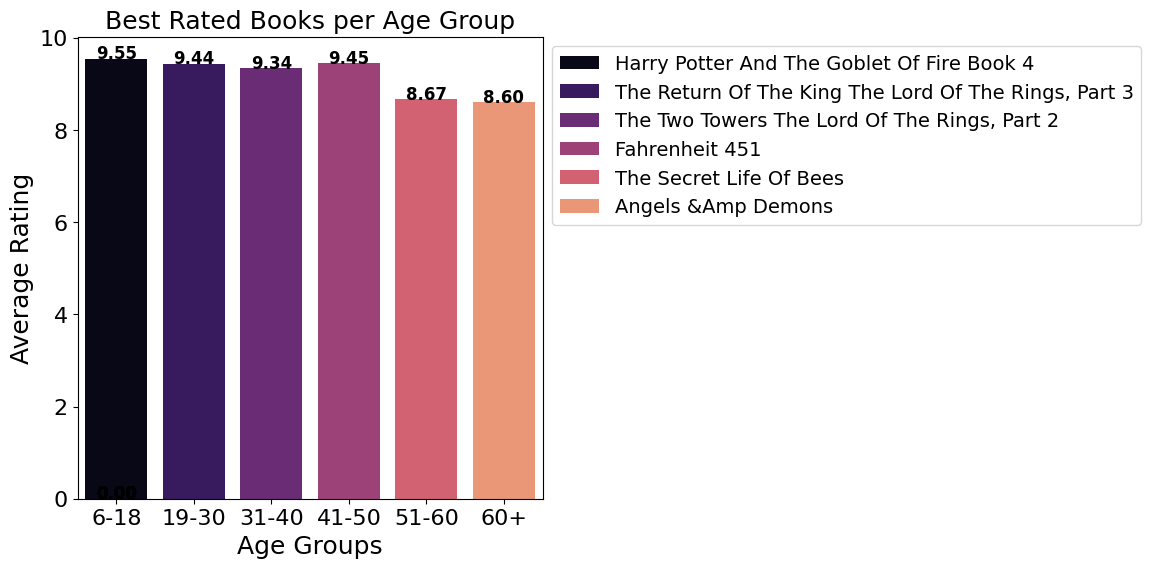

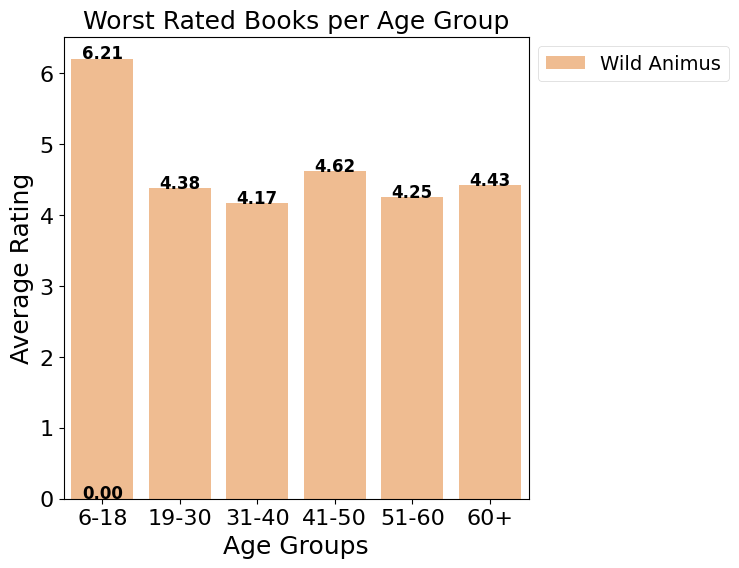

In [105]:
# Find the best and worst rated books per age group
best_rated_books = filtered_avg_ratings_by_age.loc[filtered_avg_ratings_by_age.groupby('Age-Group')['Avg-Rating'].idxmax()]
worst_rated_books = filtered_avg_ratings_by_age.loc[filtered_avg_ratings_by_age.groupby('Age-Group')['Avg-Rating'].idxmin()]

# Plot Best Rated Books per Age Group
plt.figure(figsize=(6, 6))
best_plot = sns.barplot(x='Age-Group', y='Avg-Rating', palette=magma_palette[:16:3], hue='Book-Title', data=best_rated_books)
plt.title('Best Rated Books per Age Group', fontsize=18)
plt.ylabel('Average Rating', fontsize=18)
plt.xlabel('Age Groups', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)


# Add ratings on bars
for p in best_plot.patches:
    best_plot.annotate(format(p.get_height(), '.2f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'top',
                       xytext = (0, 10), fontsize=12, fontweight='bold',
                       textcoords = 'offset points')

plt.show()

# Plot Worst Rated Books per Age Group
plt.figure(figsize=(6, 6))
worst_plot = sns.barplot(x='Age-Group', y='Avg-Rating', palette=magma_palette[17:18], hue='Book-Title', data=worst_rated_books)
plt.title('Worst Rated Books per Age Group', fontsize=18)
plt.xlabel('Age Groups', fontsize=18)
plt.ylabel('Average Rating', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)
legend.get_frame().set_linewidth(0.5)


# Add ratings on bars
for p in worst_plot.patches:
    worst_plot.annotate(format(p.get_height(), '.2f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha = 'center', va = 'top',
                        xytext = (0, 10), fontsize=12, fontweight='bold',
                        textcoords = 'offset points')

plt.show()

### Most/Least liked author per age group
We will use the same age groups from previous question.

In [106]:
# Calculate the number of ratings for each author within each age group
author_rat_counts_by_age = all_data.groupby(['Age-Group', 'Book-Author']).size().reset_index(name='Rating-Count')

# Calculate average ratings for each author within each age group
author_avg_rates_by_age = all_data.groupby(['Age-Group', 'Book-Author'])['Book-Rating'].mean().reset_index(name='Avg-Rating')

# Merge the rating counts with average ratings
author_avg_rates_by_age = pd.merge(author_avg_rates_by_age, author_rat_counts_by_age, on=['Age-Group', 'Book-Author'])

print("Rating Count Distribution")
print(author_rat_counts_by_age[author_rat_counts_by_age['Rating-Count']>10]['Rating-Count'].quantile([0.5, 0.75, 0.85, 0.95])) # to see rating count distribution
# Min ratings threshold
min_ratings_threshold = 30
filtered_author_avg_rates_by_age = author_avg_rates_by_age[author_avg_rates_by_age['Rating-Count'] >= min_ratings_threshold]

# Find the best and worst rated books per age group
best_authors = filtered_author_avg_rates_by_age.loc[filtered_author_avg_rates_by_age.groupby('Age-Group')['Avg-Rating'].idxmax()]
worst_authors= filtered_author_avg_rates_by_age.loc[filtered_author_avg_rates_by_age.groupby('Age-Group')['Avg-Rating'].idxmin()]

/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/493594995.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  author_rat_counts_by_age = all_data.groupby(['Age-Group', 'Book-Author']).size().reset_index(name='Rating-Count')
/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/493594995.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  author_avg_rates_by_age = all_data.groupby(['Age-Group', 'Book-Author'])['Book-Rating'].mean().reset_index(name='Avg-Rating')


Rating Count Distribution
0.50     21.0
0.75     40.0
0.85     62.0
0.95    147.0
Name: Rating-Count, dtype: float64


/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/493594995.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_authors = filtered_author_avg_rates_by_age.loc[filtered_author_avg_rates_by_age.groupby('Age-Group')['Avg-Rating'].idxmax()]
/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/493594995.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  worst_authors= filtered_author_avg_rates_by_age.loc[filtered_author_avg_rates_by_age.groupby('Age-Group')['Avg-Rating'].idxmin()]


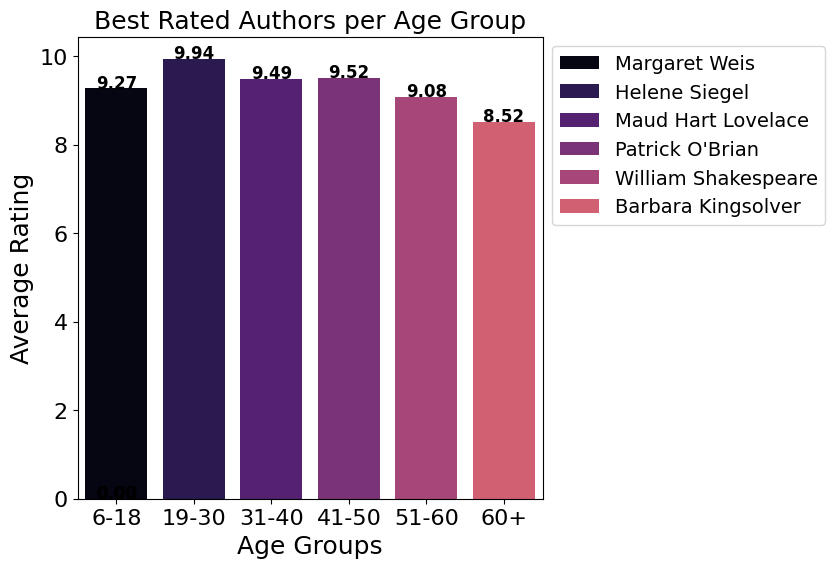

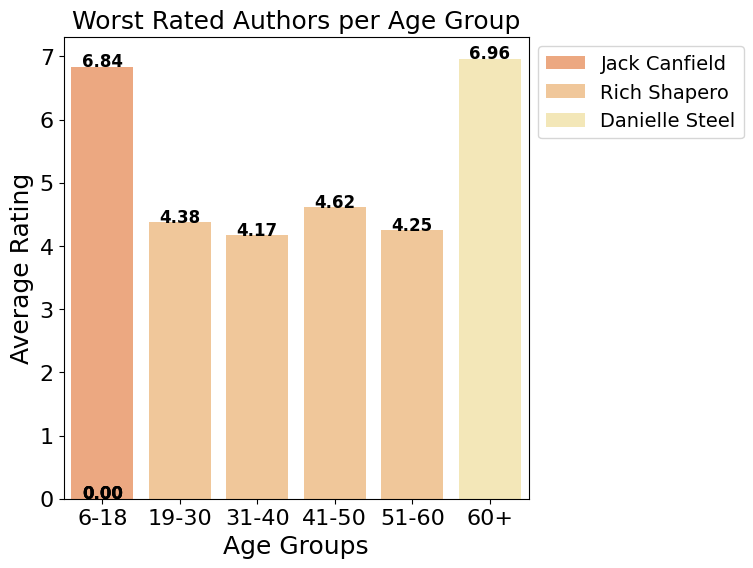

In [107]:
magma_palette = sns.color_palette("magma", n_colors=25)

# Plot Best Rated Authors per Age Group
plt.figure(figsize=(6, 6))
best_author_plot = sns.barplot(x='Age-Group', y='Avg-Rating', palette=magma_palette[:17:3], hue='Book-Author', data=best_authors)
plt.title('Best Rated Authors per Age Group', fontsize=18)
plt.ylabel('Average Rating', fontsize=18)
plt.xlabel('Age Groups', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)


# Add ratings on bars
for p in best_author_plot.patches:
    best_author_plot.annotate(format(p.get_height(), '.2f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'top',
                       xytext = (0, 10), fontsize=12, fontweight='bold',
                       textcoords = 'offset points')

plt.show()

# Plot Worst Rated Authors per Age Group
plt.figure(figsize=(6, 6))
worst_author_plot = sns.barplot(x='Age-Group', y='Avg-Rating', palette=magma_palette[20::2], hue='Book-Author', data=worst_authors)
plt.title('Worst Rated Authors per Age Group', fontsize=18)
plt.xlabel('Age Groups', fontsize=18)
plt.ylabel('Average Rating', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)

# Add ratings on bars
for p in worst_author_plot.patches:
    worst_author_plot.annotate(format(p.get_height(), '.2f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha = 'center', va = 'top',
                        xytext = (0, 10), fontsize=12, fontweight='bold',
                        textcoords = 'offset points')

plt.show()

## The Effect of Location and Age on User Ratings

### Could age be affecting how a user rates?

/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/2235316908.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_ratings = merged_data_ru.groupby('Age Group')['Book-Rating'].mean().reset_index().dropna()
/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/2235316908.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_ratings['Age Group'].astype(str), y=age_ratings['Book-Rating'], palette='magma')


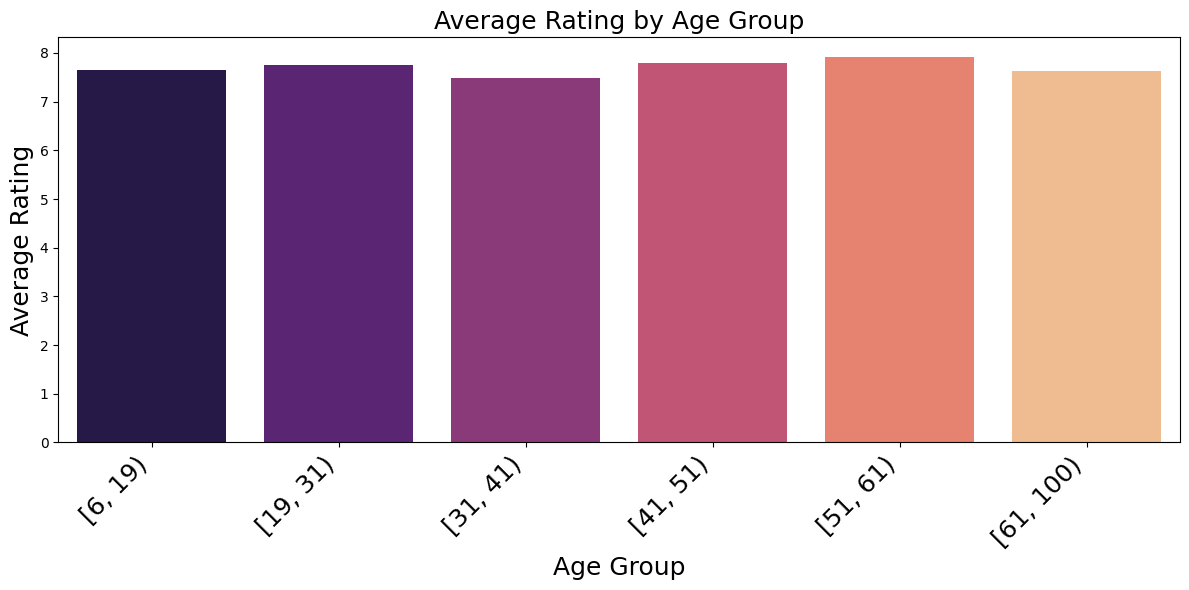

Kruskal-Wallis test results:
H-statistic: 5.0
P-value: 0.41588018699550783
No statistically significant differences between groups were found.


/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/2235316908.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  H_statistic, p_value = kruskal(*[group['Book-Rating'] for name, group in age_ratings.groupby('Age Group')])


In [108]:
merged_data_ru = ratings.merge(users, on='User-ID')

# Convert age to numeric & categorize into groups
merged_data_ru['Age'] = pd.to_numeric(merged_data_ru['Age'], errors='coerce')
merged_data_ru['Age Group'] = pd.cut(merged_data_ru['Age'], bins=[6, 19, 31, 41, 51, 61, 100], right=False)

# Calculate average ratings per group
age_ratings = merged_data_ru.groupby('Age Group')['Book-Rating'].mean().reset_index().dropna()

# Plot average ratings per age group
plt.figure(figsize=(12, 6))
sns.barplot(x=age_ratings['Age Group'].astype(str), y=age_ratings['Book-Rating'], palette='magma')
plt.xlabel('Age Group', fontsize=18)
plt.ylabel('Average Rating', fontsize=18)
plt.title('Average Rating by Age Group', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=18)
plt.tight_layout()
plt.show()


# Perform Kruskal Wallis Significance test
H_statistic, p_value = kruskal(*[group['Book-Rating'] for name, group in age_ratings.groupby('Age Group')])
print(f"Kruskal-Wallis test results:")
print(f"H-statistic: {H_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Statistically significant differences exist between at least two groups.")
    conover_results = posthoc_conover(age_ratings, val_col='Book-Rating', group_col='Age Group')
    print(conover_results)
else:
    print("No statistically significant differences between groups were found.")

### Could where a user is from (country) be affecting how a user rates?

Top 10 Countries with Highest Average Rating (at least 1000 ratings):
            Country      mean   count
141        Portugal  7.776091    3162
196             Usa  7.676143  260442
14          Austria  7.628652    1061
65           France  7.598676    4231
185  United Kingdom  7.543905   13438
32           Canada  7.506496   34713
85            Italy  7.483392    1415
13        Australia  7.463962    6951
166     Switzerland  7.451083    1523
121     New Zealand  7.440456    1755

Top 10 Countries with Lowest Average Rating (at least 1000 ratings):
            Country      mean  count
185  United Kingdom  7.543905  13438
32           Canada  7.506496  34713
85            Italy  7.483392   1415
13        Australia  7.463962   6951
166     Switzerland  7.451083   1523
121     New Zealand  7.440456   1755
107        Malaysia  7.436809   2081
68          Germany  7.426671   9996
120     Netherlands  7.286099   1856
161           Spain  7.283693   6433


/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/3480227443.py:19: UserWarning: The palette list has more values (25) than needed (14), which may not be intended.
  bars=sns.barplot(x='mean', y='Country', palette=magma_palette, hue='Country', data=country_ratings)


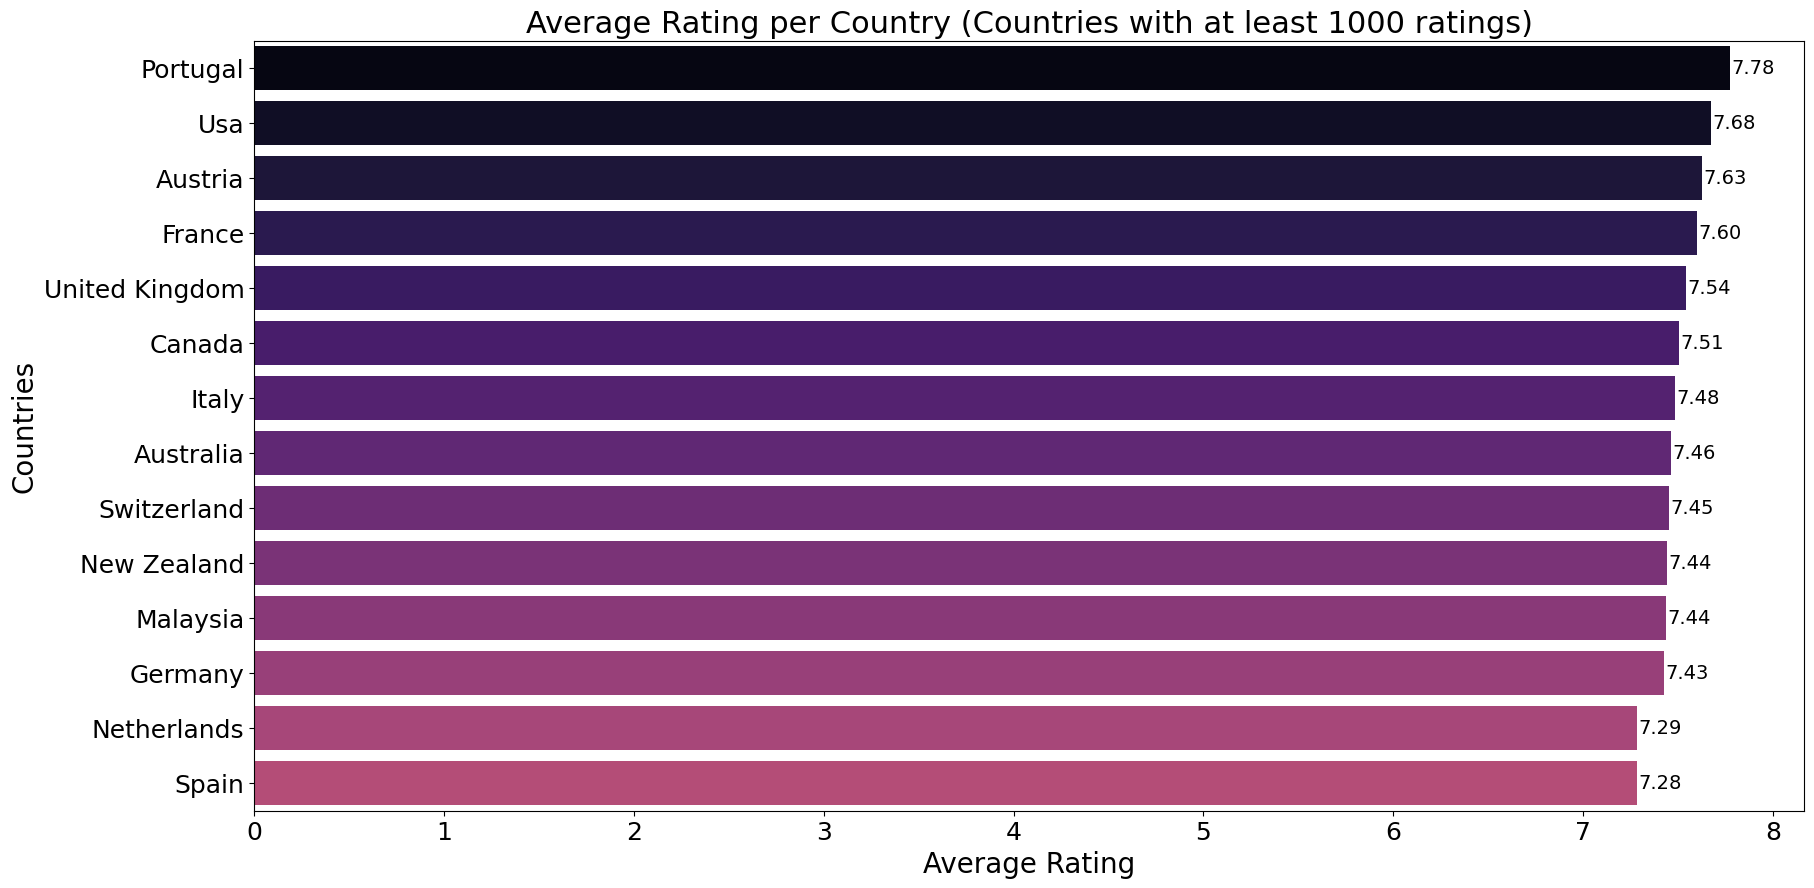

Kruskal-Wallis test statistic: 1178.3105850141333, p-value: 8.207638130530528e-244
There is a statistically significant difference between the countries' ratings.
                   Australia       Austria        Canada        France  \
Australia       1.000000e+00  3.916064e-06  4.195286e-01  1.533401e-04   
Austria         3.916064e-06  1.000000e+00  3.867191e-04  1.000000e+00   
Canada          4.195286e-01  3.867191e-04  1.000000e+00  5.155266e-02   
France          1.533401e-04  1.000000e+00  5.155266e-02  1.000000e+00   
Germany         1.000000e+00  1.017932e-03  1.000000e+00  2.627506e-01   
Italy           1.000000e+00  2.810784e-02  1.000000e+00  1.000000e+00   
Malaysia        1.000000e+00  1.683016e-04  1.000000e+00  4.863535e-02   
Netherlands     2.049216e-03  3.437653e-12  4.800423e-08  2.082744e-11   
New Zealand     1.000000e+00  1.805284e-04  1.000000e+00  5.257365e-02   
Portugal        8.420037e-12  1.000000e+00  3.739540e-09  4.267891e-01   
Spain           3.14955

In [109]:
# Merge datasets
merged_data = pd.merge(ratings, users, on='User-ID', how='left')

# Calculate average rating and rating count by grouping based on country
country_ratings = merged_data.groupby('Country')['Book-Rating'].agg(['mean', 'count']).reset_index()
country_ratings = country_ratings[country_ratings['count'] >= 1000] # Filter out countries with less than 1000 ratings
country_ratings = country_ratings.sort_values(by='mean', ascending=False)  # Sort based on avg rating

# Results
print("Top 10 Countries with Highest Average Rating (at least 1000 ratings):")
print(country_ratings.head(10))

print("\nTop 10 Countries with Lowest Average Rating (at least 1000 ratings):")
print(country_ratings.tail(10))


# Plotting
plt.figure(figsize=(20, 10))
bars=sns.barplot(x='mean', y='Country', palette=magma_palette, hue='Country', data=country_ratings)
plt.xlabel('Average Rating', fontsize=20)
plt.ylabel('Countries', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Average Rating per Country (Countries with at least 1000 ratings)', fontsize=22)

# Adding annotations
for container in bars.containers:
    bars.bar_label(container, fmt='%.2f', fontsize=14, padding=1)

plt.show()


countries_to_include = country_ratings['Country']
filtered_data = merged_data[merged_data['Country'].isin(countries_to_include)]

grouped_ratings = [group['Book-Rating'].values for name, group in filtered_data.groupby('Country')]

kruskal_result = stats.kruskal(*grouped_ratings)
print(f"Kruskal-Wallis test statistic: {kruskal_result.statistic}, p-value: {kruskal_result.pvalue}")

if kruskal_result.pvalue < 0.05:
    print("There is a statistically significant difference between the countries' ratings.")
else:
    print("There is no statistically significant difference between the countries' ratings.")
    
dunn_result = sp.posthoc_dunn(filtered_data, val_col='Book-Rating', group_col='Country', p_adjust='bonferroni')
print(dunn_result)

### Does Age Group Indicate if a User is an Extremist Rater?

Chi-Square Test Statistic: 719.1210056945338
P-Value: 3.6032133758666186e-153
There is a significant association between age group and rating type (extreme vs. moderate).
Sorted Age Group Comparison by Ratio of Extreme to Moderate Ratings:
Book-Rating Age_Group  Extreme  Moderate  Ratio_Extreme_to_Moderate
0                6-18     2197      6807                   0.322756
1               51-60     6811     25621                   0.265837
2               19-30    15164     57937                   0.261733
3               41-50     9937     41617                   0.238773
4               31-40    31450    149113                   0.210914
5                 60+     1740      8436                   0.206259


/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/3598723100.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=sorted_contingency_table_age, x='Age_Group', y='Ratio_Extreme_to_Moderate', palette='magma')


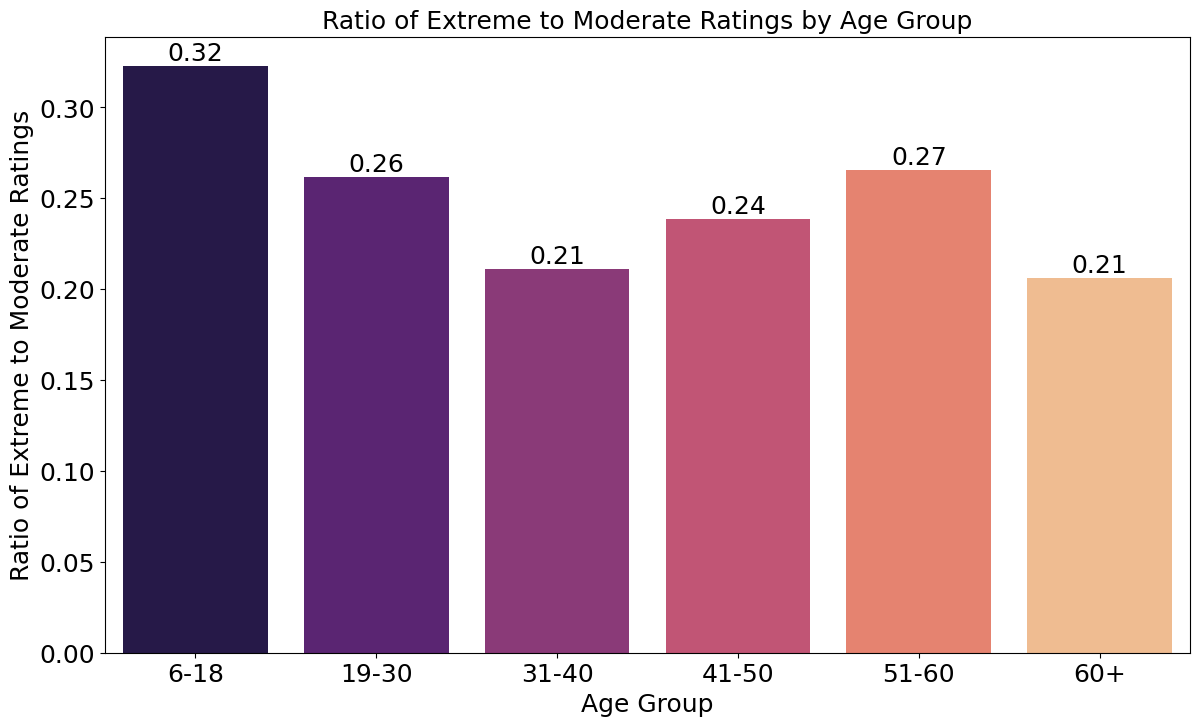

In [52]:
ratings_df = ratings.copy() #copy to avoid modifying original data
users_df = users.copy() #copy to avoid modifying original data
merged_df = pd.merge(ratings_df, users_df, on='User-ID', how='inner') #merge users and ratings data on 'User-ID'
merged_df = merged_df[merged_df['Age'].notna()] #remove rows with missing age values

#age_bins = [6, 18, 30, 65, 100] #age group bins
#age_labels = ['6-18', '18-30', '30-65', '65-100']  #age group labels
age_bins = [6, 18, 30, 40, 50, 60, 122] #age group bins
age_labels = ['6-18', '19-30', '31-40', '41-50', '51-60', '60+']  #age group labels
merged_df['Age_Group'] = pd.cut(merged_df['Age'], bins=age_bins, labels=age_labels, right=False) #define age groups

contingency_table_age = pd.crosstab(index=merged_df['Age_Group'], columns=merged_df['Book-Rating'], margins=False) #create a contingency table that includes all ratings
contingency_table_age['Extreme'] = contingency_table_age[[1, 10]].sum(axis=1) #combine the counts for ratings 1 and 10 as "Extreme" and
contingency_table_age['Moderate'] = contingency_table_age.loc[:, [2, 3, 4, 5, 6, 7, 8, 9]].sum(axis=1) #combine the counts for ratings 2-9 as "Moderate"
contingency_table_age = contingency_table_age[['Extreme', 'Moderate']] #keep only the "Extreme" and "Moderate" columns
threshold_total_reviews = 500 #threshold for minimum number of total reviews
threshold_extreme_reviews = 1 #threshold for minimum number of extreme reviews
threshold_moderate_reviews = 1 #threshold for minimum number of moderate reviews
contingency_table_age = contingency_table_age[
    (contingency_table_age['Extreme'] >= threshold_extreme_reviews) &
    (contingency_table_age['Moderate'] >= threshold_moderate_reviews) &
    ((contingency_table_age['Extreme'] + contingency_table_age['Moderate']) >= threshold_total_reviews)
] #apply the threshold

#CHI SQUARE TEST
chi2, p, dof, expected = chi2_contingency(contingency_table_age)
print(f"Chi-Square Test Statistic: {chi2}")
print(f"P-Value: {p}")
if p < 0.05: print("There is a significant association between age group and rating type (extreme vs. moderate).")
else: print("There is no significant association between age group and rating type (extreme vs. moderate).")

contingency_table_age['Ratio_Extreme_to_Moderate'] = contingency_table_age['Extreme'] / contingency_table_age['Moderate'] #calculate the ratio of extreme to moderate ratings for each age group
sorted_contingency_table_age = contingency_table_age.sort_values(by='Ratio_Extreme_to_Moderate', ascending=False).reset_index() #reset index to have 'Age_Group' as a column
print("Sorted Age Group Comparison by Ratio of Extreme to Moderate Ratings:") #display the sorted results
print(sorted_contingency_table_age) #display the sorted results

#VISUALISATION
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=sorted_contingency_table_age, x='Age_Group', y='Ratio_Extreme_to_Moderate', palette='magma')
plt.xlabel('Age Group', fontsize = 18)
plt.ylabel('Ratio of Extreme to Moderate Ratings', fontsize = 18)
plt.title('Ratio of Extreme to Moderate Ratings by Age Group', fontsize = 18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize = 18)
plt.show()


### Does Country Indicate if a User is an Extremist Rater?

Chi-Square Test Statistic: 1510.9871118209321
P-Value: 0.0000000000
There is a significant association between country and rating type (extreme vs. moderate).
Sorted Country Comparison by Ratio of Extreme to Moderate Ratings:
Book-Rating         country  Extreme  Moderate  Ratio_Extreme_to_Moderate
0                   austria      285       776                   0.367268
1                       usa    52235    208207                   0.250880
2                   germany     1890      8106                   0.233161
3                  malaysia      349      1732                   0.201501
4                     italy      234      1181                   0.198137
5                    france      672      3559                   0.188817
6                    canada     5375     29338                   0.183209
7            united kingdom     2061     11377                   0.181155
8                  portugal      445      2717                   0.163784
9               switzerland      2

/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/969046793.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=sorted_contingency_table, y='country', x='Ratio_Extreme_to_Moderate', palette='magma')


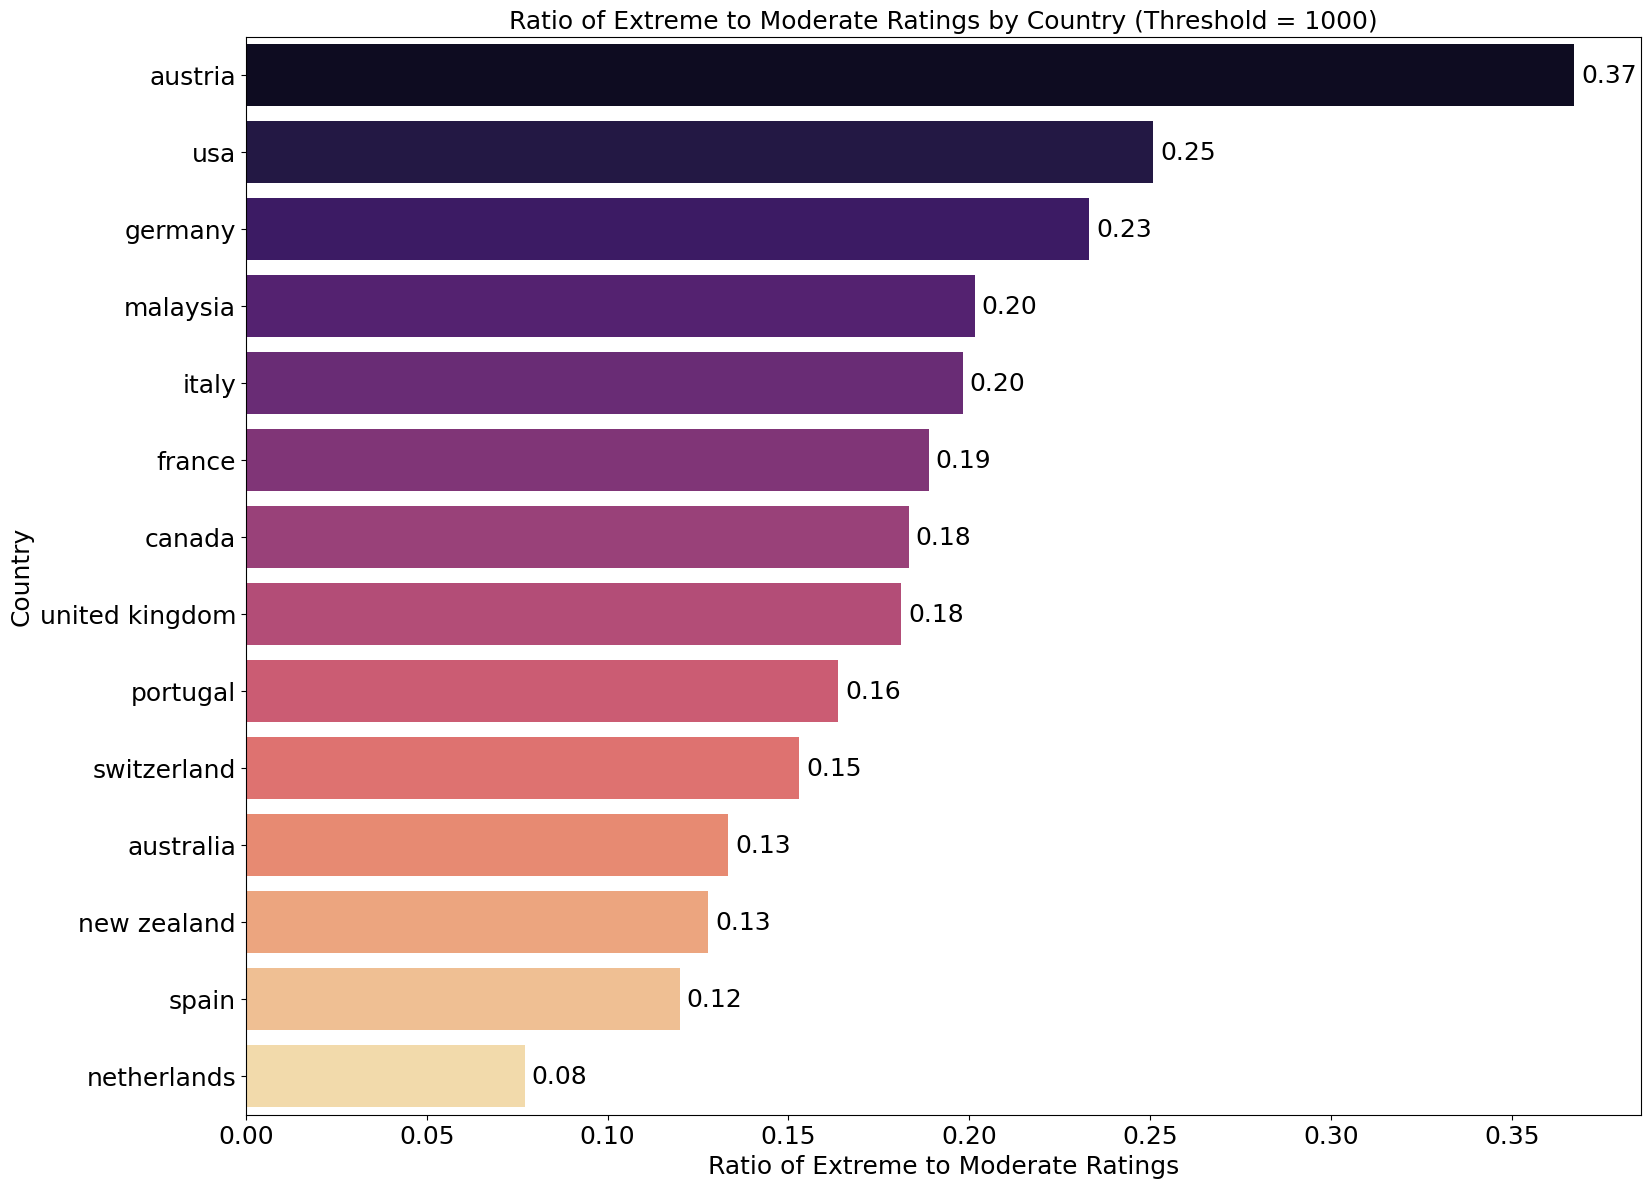

In [53]:
ratings_df = ratings.copy() #copy to avoid modifying original data
users_df = users.copy() #copy to avoid modifying original data
merged_df = pd.merge(ratings, users, on='User-ID', how='inner') #merge datadrame
merged_df['country'] = merged_df['Location'].apply(lambda x: x.split(',')[-1].strip() if pd.notnull(x) else 'Unknown') #extracr the 'Country' column from the 'Location' column
merged_df = merged_df[(merged_df['country'] != '') & (merged_df['country'] != 'n/a')] #filter out entries with empty country labels and 'n/a'

contingency_table_all_ratings = pd.crosstab(index=merged_df['country'], columns=merged_df['Book-Rating'], margins=False) #create a contingency table that includes all ratings
contingency_table_all_ratings['Extreme'] = contingency_table_all_ratings[[1, 10]].sum(axis=1) #combine the counts for ratings 1 and 10 as "Extreme"
contingency_table_all_ratings['Moderate'] = contingency_table_all_ratings.loc[:, [2, 3, 4, 5, 6, 7, 8, 9]].sum(axis=1) #combine the counts for rating 2-9 as "Moderate"
contingency_table = contingency_table_all_ratings[['Extreme', 'Moderate']] #keep only the "Extreme" and "Moderate" columns

threshold_total_reviews = 1000 #set threshold for minimum number of total reviews
threshold_extreme_reviews = 100 #set threshold for minimum number of extreme reviews
threshold_moderate_reviews = 100 #set threshold for minimum number of moderate reviews
contingency_table = contingency_table[
    (contingency_table['Extreme'] >= threshold_extreme_reviews) &
    (contingency_table['Moderate'] >= threshold_moderate_reviews) &
    ((contingency_table['Extreme'] + contingency_table['Moderate']) >= threshold_total_reviews)
] #apply the threshold

#perform the chi-square
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Test Statistic: {chi2}")
print(f"P-Value: {p:.10f}")
if p < 0.05: print("There is a significant association between country and rating type (extreme vs. moderate).")
else: print("There is no significant association between country and rating type (extreme vs. moderate).")

contingency_table['Ratio_Extreme_to_Moderate'] = contingency_table['Extreme'] / contingency_table['Moderate'] #calculate the ratio of extreme to moderate ratings for each country
sorted_contingency_table = contingency_table.sort_values(by='Ratio_Extreme_to_Moderate', ascending=False).reset_index() #reset index to have 'Country' as a column
print("Sorted Country Comparison by Ratio of Extreme to Moderate Ratings:") #display the sorted results
print(sorted_contingency_table) #display the sorted results

#VISUALISATION
plt.figure(figsize=(18, 14))
ax = sns.barplot(data=sorted_contingency_table, y='country', x='Ratio_Extreme_to_Moderate', palette='magma')
plt.xlabel('Ratio of Extreme to Moderate Ratings', fontsize = 18)
plt.ylabel('Country', fontsize = 18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title('Ratio of Extreme to Moderate Ratings by Country (Threshold = 1000)', fontsize = 18)
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.2f}',
                (width, p.get_y() + p.get_height() / 2.),
                ha='center', va='center',
                xytext=(25, 0),
                textcoords='offset points',
                fontsize=18, color='black')
plt.show()



## Gender Bias


In [55]:
d = gender.Detector() #init gender detector

def get_gender(name): #gender determiner function
    if isinstance(name, str): #check if string
        first_name = name.split()[0] #get the first name
        return d.get_gender(first_name) #return gender
    return 'unknown'

Count of Authors per Gender:
Author_Gender
andy               859
female           30504
male             47529
mostly_female     3094
mostly_male       2176
unknown          15028
Name: Book-Author, dtype: int64


/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/1707732108.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=author_gender_counts.index, y=author_gender_counts.values, palette=custom_colors)


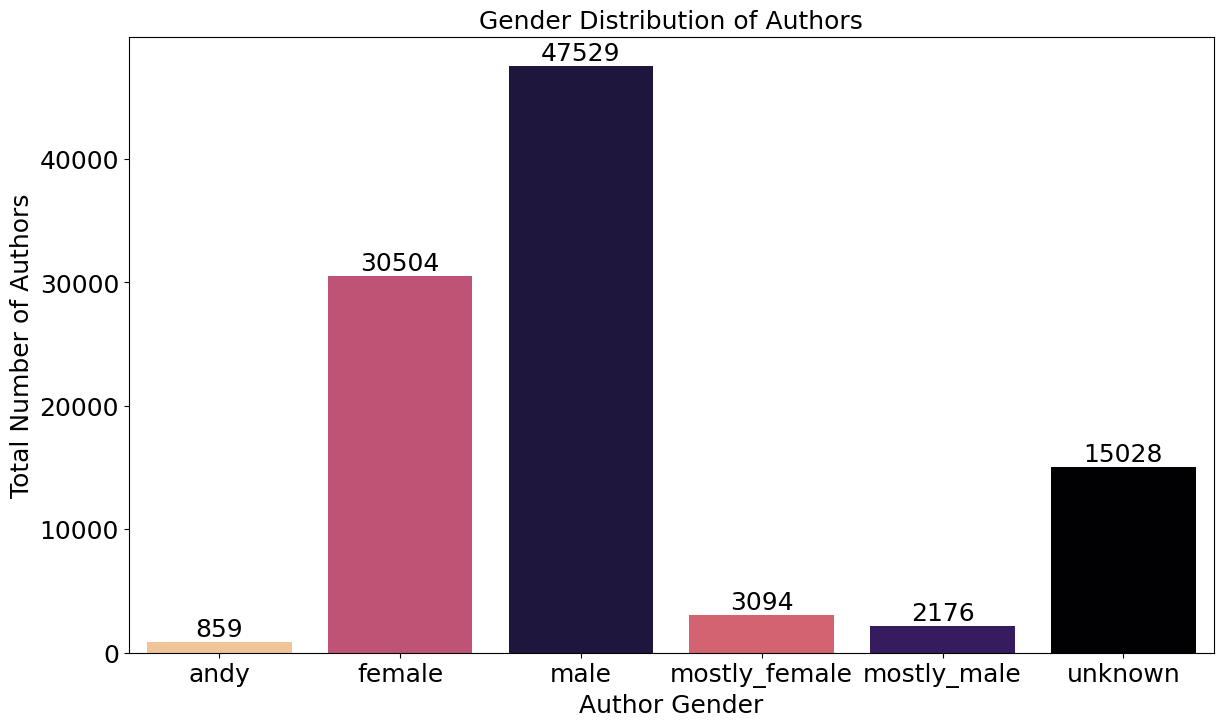

In [56]:
books_df = books.copy() #copy to avoid modifying original data
books_df['Author_Gender'] = books_df['Book-Author'].apply(get_gender) #add gender columns
author_gender_counts = books_df.groupby('Author_Gender')['Book-Author'].nunique() #get the gender counts
print("Count of Authors per Gender:") #display gender counts
print(author_gender_counts) #display gender counts

#VISUALISATION
plt.figure(figsize=(14, 8))
magma_palette = sns.color_palette("magma", n_colors=256)
custom_colors = [magma_palette[224], magma_palette[144], magma_palette[30], magma_palette[159], magma_palette[47], magma_palette[0]]
ax = sns.barplot(x=author_gender_counts.index, y=author_gender_counts.values, palette=custom_colors)
plt.title('Gender Distribution of Authors', fontsize = 18)
plt.xlabel('Author Gender', fontsize=18)
plt.ylabel('Total Number of Authors', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize = 18)
plt.show()


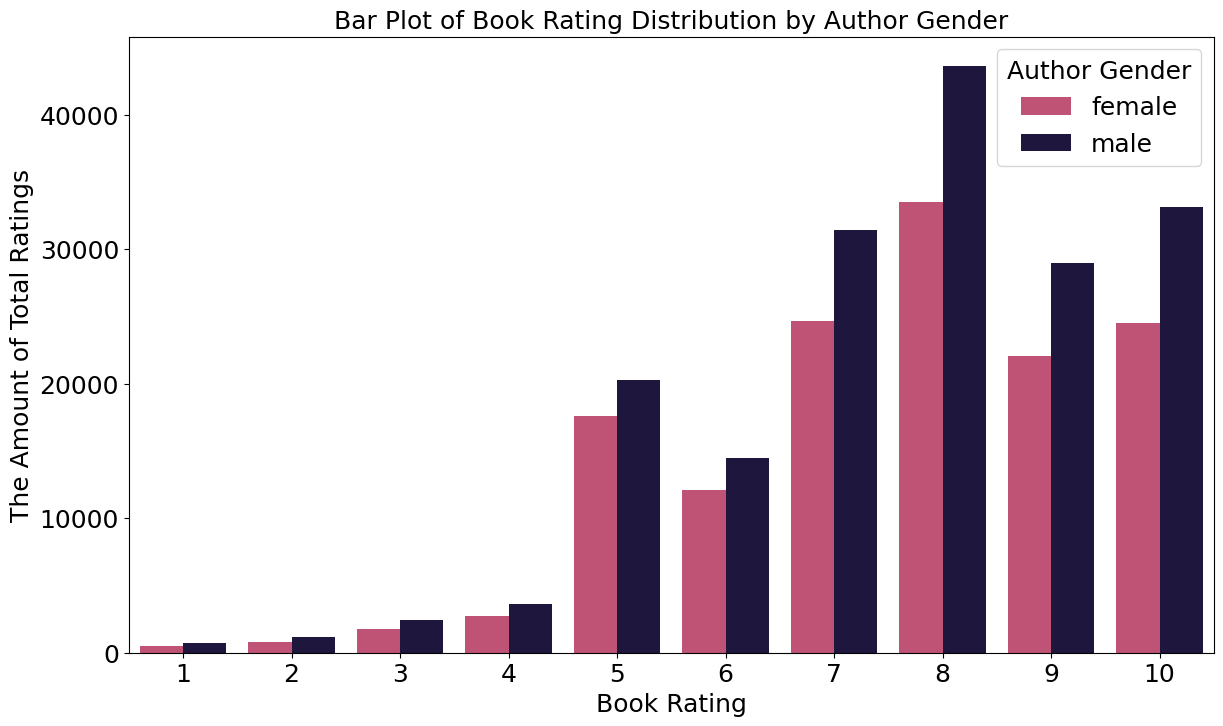

Mean Rating for Male Authors: 7.64
Mean Rating for Female Authors: 7.58
Median Rating for Male Authors: 8.00
Median Rating for Female Authors: 8.00
One-sided Mann-Whitney U test: U statistic = 12319899979.5, p-value = 0.0000000000
Effect Size (Rank-Biserial Correlation): -0.022
There is a statistically significant difference indicating that female authors are rated lower than male authors.


In [57]:
merged_df = pd.merge(ratings_df, books_df, on='ISBN', how='inner') #merge datasets with inner join to include only ratings with corresponding books
merged_df['Author_Gender'] = merged_df['Author_Gender'].fillna('unknown') #fill invalid rows with unknown
merged_df = merged_df[merged_df['Book-Rating'] != 0] #only have the explicit ratings
filtered_df = merged_df[merged_df['Author_Gender'].isin(['male', 'female'])] #filter out unknown gender

male_ratings = filtered_df[filtered_df['Author_Gender'] == 'male']['Book-Rating'] #extract male ratings
female_ratings = filtered_df[filtered_df['Author_Gender'] == 'female']['Book-Rating'] #extract female ratings

#VISUALISATION
rating_gender_counts = filtered_df.groupby(['Book-Rating', 'Author_Gender']).size().reset_index(name='Count')
plt.figure(figsize=(14, 8))
magma_palette = sns.color_palette("magma", n_colors=256)
sns.barplot(data=rating_gender_counts, x='Book-Rating', y='Count', hue='Author_Gender', palette={'male': magma_palette[30], 'female': magma_palette[144]})
plt.title('Bar Plot of Book Rating Distribution by Author Gender', fontsize=18)
plt.xlabel('Book Rating', fontsize=18)
plt.ylabel('The Amount of Total Ratings', fontsize=18)
plt.legend(title='Author Gender', title_fontsize='18', prop={'size': 18})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

mean_male = male_ratings.mean() #retrieve male mean
mean_female = female_ratings.mean() #retrieve female mean
median_male = male_ratings.median() #retrieve male median
median_female = female_ratings.median() #retrieve female median
print(f"Mean Rating for Male Authors: {mean_male:.2f}")
print(f"Mean Rating for Female Authors: {mean_female:.2f}")
print(f"Median Rating for Male Authors: {median_male:.2f}")
print(f"Median Rating for Female Authors: {median_female:.2f}")


u_stat, p_value = mannwhitneyu(female_ratings, male_ratings, alternative='less') #perform the one-sided Mann-Whitney U test
n1 = len(female_ratings) #retrieve length of female ratings
n2 = len(male_ratings) #retrieve length of male ratings
effect_size = (2 * u_stat) / (n1 * n2) - 1 # Calculate the Rank-Biserial Correlation as the effect size

#TEST RESULTS
print(f"One-sided Mann-Whitney U test: U statistic = {u_stat}, p-value = {p_value:.10f}")
print(f"Effect Size (Rank-Biserial Correlation): {effect_size:.3f}")
if p_value < 0.05: print("There is a statistically significant difference indicating that female authors are rated lower than male authors.")
else: print("There is no statistically significant difference indicating that female authors are rated lower than male authors.")


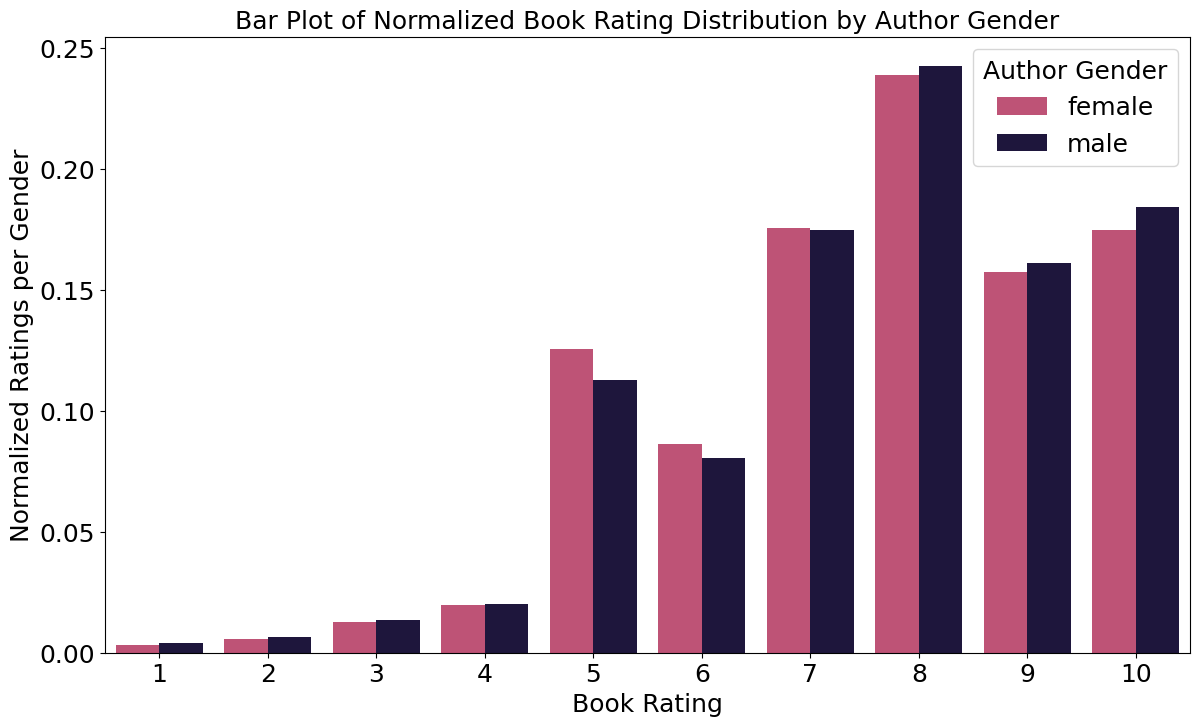

Mann-Whitney U test on Normalized Counts: U statistic = 47.0, p-value = 0.4250533696
There is no statistically significant difference in the normalized distributions indicating that female authors are rated lower than male authors.


In [58]:
total_ratings_by_gender = filtered_df['Author_Gender'].value_counts() #calculate total ratings for each gender

#NORMALIZATION
rating_gender_counts = filtered_df.groupby(['Book-Rating', 'Author_Gender']).size().reset_index(name='Count')
rating_gender_counts['Normalized_Count'] = rating_gender_counts.apply(
    lambda row: row['Count'] / total_ratings_by_gender[row['Author_Gender']], axis=1
)

#VISUALISATION
plt.figure(figsize=(14, 8))
magma_palette = sns.color_palette("magma", n_colors=256)
sns.barplot(data=rating_gender_counts, x='Book-Rating', y='Normalized_Count', hue='Author_Gender', palette={'male': magma_palette[30], 'female': magma_palette[144]})
plt.title('Bar Plot of Normalized Book Rating Distribution by Author Gender', fontsize=18)
plt.xlabel('Book Rating', fontsize=18)
plt.ylabel('Normalized Ratings per Gender', fontsize=18)
plt.legend(title='Author Gender', title_fontsize='18', prop={'size': 18})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


male_normalized_ratings = rating_gender_counts[rating_gender_counts['Author_Gender'] == 'male']['Normalized_Count'] #extract normalized ratings for male
female_normalized_ratings = rating_gender_counts[rating_gender_counts['Author_Gender'] == 'female']['Normalized_Count']  #extract normalized ratings for female
u_stat, p_value = mannwhitneyu(female_normalized_ratings, male_normalized_ratings, alternative='less') #perform the Mann-Whitney U test on normalized counts

#TEST RESULTS
print(f"Mann-Whitney U test on Normalized Counts: U statistic = {u_stat}, p-value = {p_value:.10f}")
if p_value < 0.05: print("There is a statistically significant difference in the normalized distributions indicating that female authors are rated lower than male authors.")
else: print("There is no statistically significant difference in the normalized distributions indicating that female authors are rated lower than male authors.")


Shapiro-Wilk Test for Male Ratings: Statistic=0.9221, p-value=0.0000
Shapiro-Wilk Test for Female Ratings: Statistic=0.9274, p-value=0.0000
Levene's Test for Homogeneity of Variances: Statistic=11.4238, p-value=0.0007
Mean Rating for Male Authors: 7.64
Mean Rating for Female Authors: 7.58
Welch's t-test: t-statistic = 9.3631, p-value = 0.0000000000
There is a statistically significant difference between the average ratings of male and female authors.


/opt/anaconda3/envs/pbd/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 179744.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/pbd/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 140130.
  res = hypotest_fun_out(*samples, **kwds)
/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/525981450.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Author_Gender', y='Book-Rating', data=filtered_df, palette={'male': magma_palette[30], 'female': magma_palette[144]})


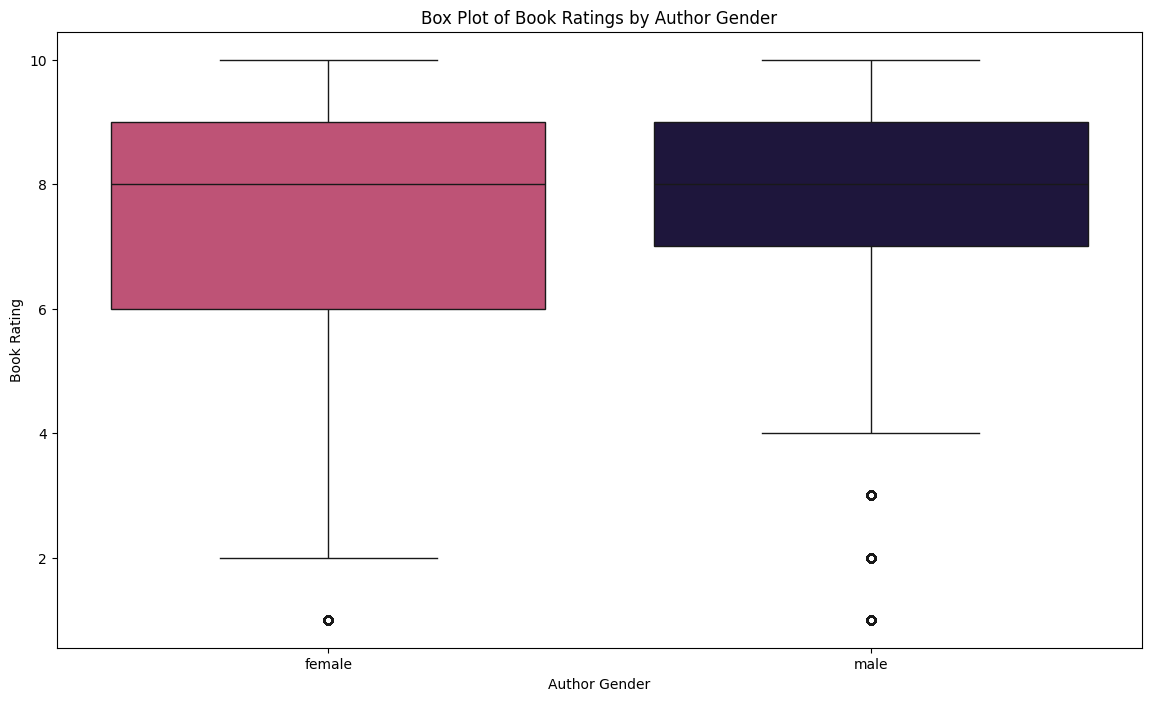

In [59]:
shapiro_male = shapiro(male_ratings) #check for normality of male rating dist
shapiro_female = shapiro(female_ratings) #check for normality of female rating dist
print("Shapiro-Wilk Test for Male Ratings: Statistic=%.4f, p-value=%.4f" % shapiro_male)
print("Shapiro-Wilk Test for Female Ratings: Statistic=%.4f, p-value=%.4f" % shapiro_female)

levene_test = levene(male_ratings, female_ratings) #check for homogeneity of variances
print("Levene's Test for Homogeneity of Variances: Statistic=%.4f, p-value=%.4f" % levene_test)

#TESTING
#use t-test if both distributions are normal and variances are equal
#conduct Welch's t-test otherwise
if shapiro_male.pvalue > 0.05 and shapiro_female.pvalue > 0.05 and levene_test.pvalue > 0.05:
    t_stat, t_p_value = ttest_ind(male_ratings, female_ratings)
    print("Two-sample t-test: t-statistic = %.4f, p-value = %.10f" % (t_stat, t_p_value))
else:
    mean_male = male_ratings.mean()
    std_male = male_ratings.std()
    n_male = male_ratings.count()
    mean_female = female_ratings.mean()
    std_female = female_ratings.std()
    n_female = female_ratings.count()
    print(f"Mean Rating for Male Authors: {mean_male:.2f}")
    print(f"Mean Rating for Female Authors: {mean_female:.2f}")
    t_stat, p_value = ttest_ind_from_stats(mean1=mean_male, std1=std_male, nobs1=n_male,
                                       mean2=mean_female, std2=std_female, nobs2=n_female, equal_var=False)
    print(f"Welch's t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.10f}")

    if p_value < 0.05: print("There is a statistically significant difference between the average ratings of male and female authors.")
    else: print("There is no statistically significant difference between the average ratings of male and female authors.")

#VISUALISATION
plt.figure(figsize=(14, 8))
magma_palette = sns.color_palette("magma", n_colors=256)
sns.boxplot(x='Author_Gender', y='Book-Rating', data=filtered_df, palette={'male': magma_palette[30], 'female': magma_palette[144]})
plt.title('Box Plot of Book Ratings by Author Gender')
plt.xlabel('Author Gender')
plt.ylabel('Book Rating')
plt.show()


## Sentiment Analysis with VADER

Sentiment Analysis of Book Titles using VADER

In [61]:
nltk.download('vader_lexicon') #download VADER lexicon
sia = SentimentIntensityAnalyzer() #initialize VADER sentiment analyzer

def get_sentiment(title): #function to calculate sentiment scores
    sentiment = sia.polarity_scores(title)
    return sentiment['compound']

def categorize_sentiment(compound_score): #function to categorize the sentiment scores based on VADER thresholds
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sinemis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


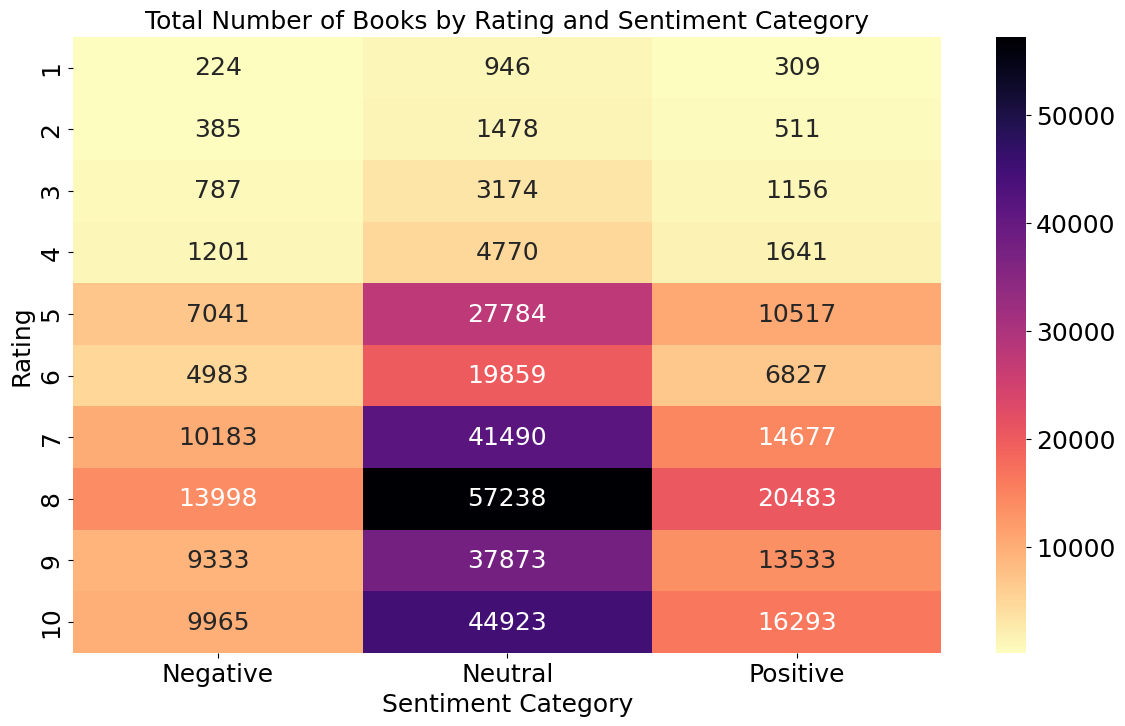

Spearman correlation between sentiment and ratings: correlation = 0.0092, p-value = 0.0000000144
The correlation between sentiment and ratings is statistically significant.


In [62]:
books_df = books.copy() #copy to acoid modifying original data
ratings_df = ratings.copy() #copy to acoid modifying original data
books_df['Sentiment'] = books_df['Book-Title'].apply(get_sentiment) #add a column for sentiment in books_df
books_df['Sentiment_Category'] = books_df['Sentiment'].apply(categorize_sentiment) #add a column for sentiment category in books_df
merged_df = pd.merge(ratings_df, books_df, on='ISBN', how='inner') #merge datasets with inner join to include only ratings with corresponding books
merged_df = merged_df[merged_df['Book-Rating'] != 0] #filter out ratings of 0

#VISUALISATION
pivot_table = merged_df.pivot_table(index='Book-Rating', columns='Sentiment_Category', aggfunc='size', fill_value=0)
plt.figure(figsize=(14, 8))
heatmap = sns.heatmap(pivot_table, annot=True, fmt='d', cmap='magma_r', annot_kws={"size": 18})
plt.title('Total Number of Books by Rating and Sentiment Category', fontsize = 18)
plt.xlabel('Sentiment Category', fontsize = 18)
plt.ylabel('Rating', fontsize = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=18)
plt.show()

#SPEARMAN CORRELATION
correlation, p_value = spearmanr(merged_df['Sentiment'], merged_df['Book-Rating'])
print(f'Spearman correlation between sentiment and ratings: correlation = {correlation:.4f}, p-value = {p_value:.10f}')
if p_value < 0.05: print("The correlation between sentiment and ratings is statistically significant.")
else: print("The correlation between sentiment and ratings is not statistically significant.")


# Prediction of age and country

First we adapt the datasets so that we can use them to train our model. We add columns of users' favorite books and average ratings. We concatanate the books into a list to make the training more convenient. The categorical features will be encoded with encoders like one-hot encoder later.

In [63]:
# Merge datasets of users and ratings
merged_users_ratings = pd.merge(users, ratings, on='User-ID')

# Calculate the number of ratings per user and create a new column accordingly
ratings_count = merged_users_ratings['User-ID'].value_counts().reset_index()
ratings_count.columns = ['User-ID', 'Num-Ratings']
merged_users_ratings_counts = pd.merge(merged_users_ratings, ratings_count, on='User-ID')

# Select only users with more than 25 ratings
new_usesrs = merged_users_ratings_counts[merged_users_ratings_counts['Num-Ratings'] >= 25]
new_usesrs.reset_index(drop=True)

users_and_books = new_usesrs.merge(books, on='ISBN')
average_ratings = users_and_books.groupby('User-ID')['Book-Rating'].mean().reset_index().rename(columns={'Book-Rating': 'Average-Rating'})
users_and_books = pd.merge(users_and_books, average_ratings, on='User-ID')

In [64]:
# Select favorite 25 books of users in the dataset
favorite_books = (
    users_and_books.groupby('User-ID')
    .apply(lambda x: x.nlargest(25, 'Book-Rating')[['User-ID', 'Country', 'Average-Rating', 'Book-Title', 'ISBN', 'Age', 'Publisher', 'Num-Ratings']])
    .reset_index(drop=True)
)
# Get the country information of users
# Aggragate the favorites of users as a list to allow future analysis
user_favorites = pd.merge(users, favorite_books, on='User-ID', how='left')
user_favorites = user_favorites.groupby(['User-ID', 'Country_x', 'Average-Rating', 'Age_x', 'Num-Ratings'])['Book-Title'].agg(list).reset_index()

/var/folders/k4/58l6krg105x6d60tz9mc03b80000gn/T/ipykernel_30724/3119099465.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(25, 'Book-Rating')[['User-ID', 'Country', 'Average-Rating', 'Book-Title', 'ISBN', 'Age', 'Publisher', 'Num-Ratings']])


## Age prediction model

Here we define models for training age and country prediction models, whose structures are the same. MLPs with 1 input layer, 2 hidden layers and 1 output layer. We use the relu as the activation function. Then we train the models and test it with the preserved testing dataset. We print the error or accuracy of prediction over epochs of training to see how the model is improved over training epochs.

In [65]:
# Encode categorical features
encoder = OneHotEncoder(sparse_output=False)
encoded_country = encoder.fit_transform(user_favorites[['Country_x']])
encoded_country_df = pd.DataFrame(encoded_country, columns=encoder.get_feature_names_out(['Country_x']))
user_infor = pd.concat([user_favorites, encoded_country_df], axis=1).drop(['Country_x'], axis=1)
# Encode multiple labels feeatures
mlb = MultiLabelBinarizer()
favorite_books_encoded = mlb.fit_transform(user_infor['Book-Title'])
favorite_books_encoded_df = pd.DataFrame(favorite_books_encoded, columns=mlb.classes_)

# Combine with original dataset and generate a new dataset for model training
user_infor = pd.concat([user_infor, favorite_books_encoded_df], axis=1).drop(['Book-Title'], axis=1)

# We drop the label and irrelevent information
X = user_infor.drop(['User-ID', 'Age_x'], axis=1)
y = user_infor['Age_x']

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1978, 33505) (495, 33505) (1978,) (495,)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 554.9724 - mae: 17.9839 - val_loss: 210.3993 - val_mae: 10.6552
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 178.2361 - mae: 9.2644 - val_loss: 169.9824 - val_mae: 9.4801
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - loss: 179.6481 - mae: 7.7992 - val_loss: 151.2868 - val_mae: 8.9495
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 41.5788 - mae: 4.6896 - val_loss: 143.4222 - val_mae: 8.7112
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - loss: 12.8658 - mae: 2.3543 - val_loss: 214.5238 - val_mae: 10.8372
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 20.6923 - mae: 2.5661 - val_loss: 349.6927 - val_mae: 14.3674
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - loss: 112.3897 - mae: 6.2580 - val_loss: 132.3401 - val_mae: 8.5207
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 32.8360 - mae: 4.2590 - val_loss: 176.8826 - val_mae: 9.8159
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 62

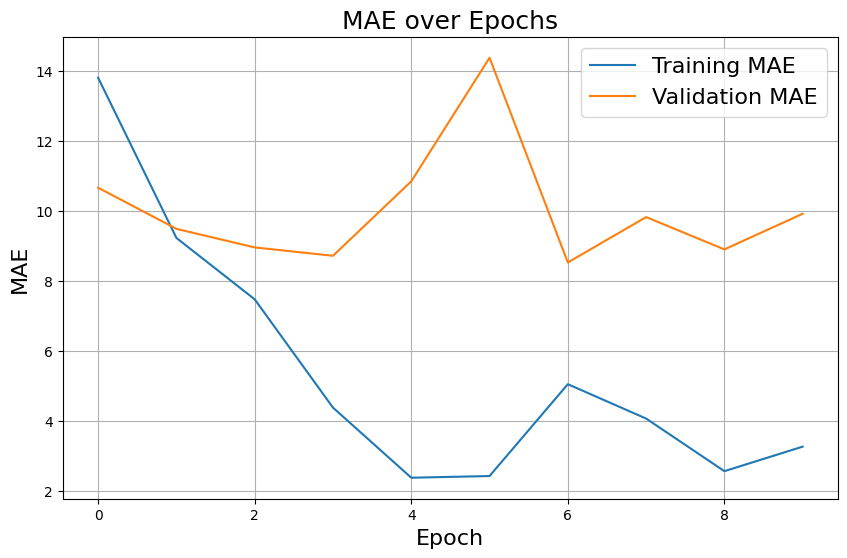

In [66]:
# Define the MLP modelfor predicting age
age_model = keras.Sequential([
    Input(shape=(33505,)),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(1)
])

# Compile and train the model
age_model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])
history = age_model.fit(X_train, y_train, epochs=10, validation_split=0.1)

# Evaluate the model with testing data
loss, mae = age_model.evaluate(X_test, y_test)
print(f"Test MAE: {mae}")

# Plot the result of training process
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs', fontsize = 18)
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('MAE', fontsize = 16)
plt.legend(fontsize = 16)
plt.grid(True)
plt.show()

## Country prediction model

In [67]:
# Only preserve information related to the prediction in the training dataset
user_infor = user_favorites.drop(['Country_x', 'User-ID'], axis=1)
# Convert favorite books list to binary features using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
favorite_books_encoded = mlb.fit_transform(user_infor['Book-Title'])
favorite_books_encoded_df = pd.DataFrame(favorite_books_encoded, columns=mlb.classes_)

# Combine with original dataset
user_infor = pd.concat([user_infor, favorite_books_encoded_df], axis=1).drop(['Book-Title'], axis=1)

# Encode user information, create feature space and label space
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(user_infor)  # One-hot encode favorite books
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(user_favorites["Country_x"])
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.4667 - loss: 26.6028 - val_accuracy: 0.7121 - val_loss: 3.5531
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 239ms/step - accuracy: 0.6830 - loss: 2.5671 - val_accuracy: 0.7121 - val_loss: 1.5417
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 233ms/step - accuracy: 0.7069 - loss: 1.3926 - val_accuracy: 0.7121 - val_loss: 1.5654
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 237ms/step - accuracy: 0.7036 - loss: 1.4205 - val_accuracy: 0.7121 - val_loss: 1.4751
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 339ms/step - accuracy: 0.7138 - loss: 1.3206 - val_accuracy: 0.7121 - val_loss: 1.5225
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 265ms/step - accuracy: 0.7234 - loss: 1.2705 - val_accuracy: 0.7121 - val_loss: 1.4795
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 293ms/step - accuracy: 0.7243 - loss: 1.2290 - val_accuracy: 0.7121 - val_loss: 1.4688
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - accuracy: 0.7325 - loss: 1.2895 - val_acc

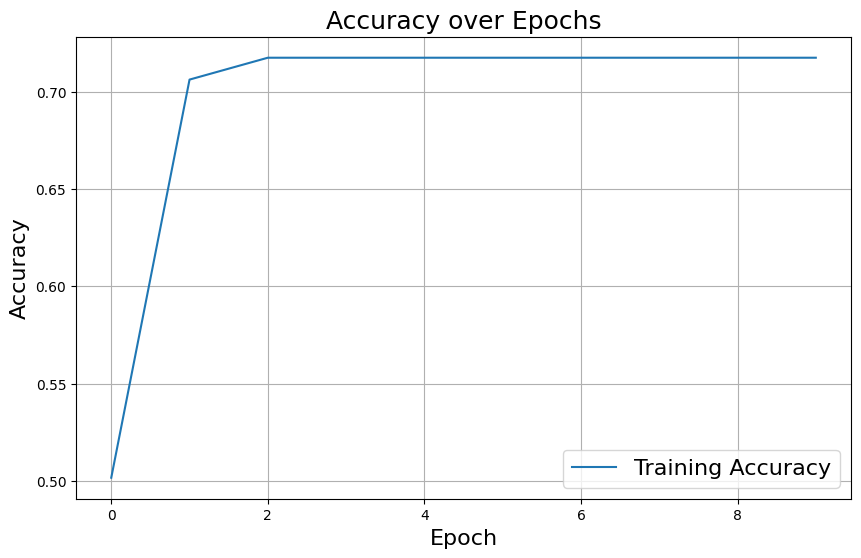

In [68]:
# Define the model for predicting countries
country_model = keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer for classification
])

# Compile the model
country_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = country_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = country_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Plot the training accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Accuracy over Epochs', fontsize = 18)
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.legend(fontsize = 16)
plt.grid(True)
plt.show()

### Recommendation System

In [112]:
# Calculate Euclidean distance
def euclidSim(inA, inB):
    return 1.0 / (1.0 + np.linalg.norm(inA - inB))

def pearsonSim(inA, inB):
    if len(inA) < 3:
        return 1.0
    return 0.5 + 0.5 * np.corrcoef(inA, inB, rowvar=0)[0][1]

# Singular Value Decomposition
def svdEst(dataMat, user, simMeas, item):
    n = np.shape(dataMat)[1]
    simTotal = 0.0
    ratSimTotal = 0.0
    data = np.mat(dataMat)
    U, Sigma, VT = np.linalg.svd(data)
    Sig4 = np.mat(np.eye(4) * Sigma[:4])  
    xformedItems = data.T * U[:, :4] * Sig4.I  # transformed items
    for j in range(n):
        userRating = data[user, j]
        if userRating == 0 or j == item:
            continue
        similarity = simMeas(xformedItems[item, :].T, xformedItems[j, :].T)
        simTotal += similarity
        ratSimTotal += similarity * userRating
    if simTotal == 0:
        return 0
    else:
        return ratSimTotal / simTotal

# Create a subset of users (with at least 20 ratings)
def create_users_subset(ratings, min_ratings=20, high_rating_threshold=7):

    user_ratings_count = ratings['User-ID'].value_counts()
    users_with_enough_ratings = user_ratings_count[user_ratings_count >= min_ratings].index.tolist()
    ratings_subset = ratings[ratings['User-ID'].isin(users_with_enough_ratings)]

    # Filter ratings (only >7)
    high_ratings_subset = ratings_subset[ratings_subset['Book-Rating'] >= high_rating_threshold]

    # Count ratings per user in subset
    user_ratings_counts = high_ratings_subset['User-ID'].value_counts()

    # Filter users (with at least 20 high ratings)
    users_with_enough_high_ratings = user_ratings_counts[user_ratings_counts >= min_ratings].index.tolist()
    final_users_subset = high_ratings_subset[high_ratings_subset['User-ID'].isin(users_with_enough_high_ratings)]

    return final_users_subset

# Train the recommendation model
def train_recommendation_model(users_data):
    book_pivot = users_data.pivot(index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)
    data = np.mat(book_pivot.values)

    # Singular Value Decomposition 
    U, Sigma, VT = np.linalg.svd(data)

    return U, Sigma, VT, book_pivot

# Get recommendations for a user
def get_user_recommendations(user_id, ratings, books, num_recommendations=5, U=None, Sigma=None, VT=None, book_pivot=None):
    recommendations = recommend(data, user_id, N=num_recommendations, simMeas=pearsonSim, estMethod=svdEst)

    # Get book details for recommendation
    recommended_books = []
    for item in recommendations:
        recommended_books.append(books.loc[books['ISBN'] == book_pivot.index[item[0]], ['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']].values.tolist())

    return recommended_books

# Test recommendation model
def test_recommendation_model(users_data, ratings, books, U=None, Sigma=None, VT=None, book_pivot=None):
    # Randomly select a user
    random_user_id = random.choice(users_data['User-ID'].unique())

    # Get recommendations 
    recommendations = get_user_recommendations(random_user_id, ratings, books, U=U, Sigma=Sigma, VT=VT, book_pivot=book_pivot)

    if not recommendations:
        print(f"No recommendations available for User ID {random_user_id}.")
    else:
        print(f"Recommendations for User ID {random_user_id}:")
        for book in recommendations:
            print(f"Book: {book[0][0]} by {book[0][1]}, Published by {book[0][3]}")

def recommendation_run():
    # Create subset of users (with enough ratings and high-rated books)
    users_subset = create_users_subset(ratings)

    num_users_subset = len(users_subset['User-ID'].unique())
    print(f"Number of users in subset: {num_users_subset}")

    # Train recommendation model with subset
    U, Sigma, VT, book_pivot = train_recommendation_model(users_subset)

    # Test recommendation model
    test_recommendation_model(users_subset, ratings, books, U=U, Sigma=Sigma, VT=VT, book_pivot=book_pivot)

# Kernel keep crashing, code included to show untested model
#recommendation_run()

Kernel keep crashing, code included to show untested model,
uncomment the last code above to see this
